# Introduction

## Objective
Develop a model that classifies clouds into one of two types. 

## Key findings
* A classifier with very high accuracy has been developed that is ready for production. 

## Next steps
* Move model over to scripts for productionalization

## Imports and setup

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import sys
import os
import json
import warnings
warnings.filterwarnings('ignore')

# basic plotting and data manipulation
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# For modeling
import sklearn
import sklearn.ensemble

# for appending dates to filenames
import datetime

In [4]:
# Test .yaml file
import yaml

with open("plots_config.yaml", "r") as f:
    config = yaml.safe_load(f)

config

{'font': {'size': 16, 'family': 'sans-serif', 'sans_serif': 'Tahoma'},
 'axes': {'prop_cycle': ['#0085ca',
   '#888b8d',
   '#00c389',
   '#f4364c',
   '#e56db1'],
  'label_size': 20,
  'label_color': '#677385',
  'title_size': 20},
 'x_ticks': {'label_size': 14},
 'y_ticks': {'label_size': 14},
 'text': {'color': '#677385'},
 'lines': {'color': '#0055A7', 'width': 3},
 'figures': {'width': 12.0, 'height': 8.0}}

In [5]:
from cycler import cycler

# Update matplotlib defaults to something nicer
mpl_update = {
    'font.size': config['font']['size'],
    'axes.prop_cycle': cycler('color', config['axes']['prop_cycle']),
    'xtick.labelsize': config['x_ticks']['label_size'],
    'ytick.labelsize': config['y_ticks']['label_size'],
    'figure.figsize': [config['figures']['width'], 
                       config['figures']['height']],
    'axes.labelsize': config['axes']['label_size'],
    'axes.labelcolor': config['axes']['label_color'],
    'axes.titlesize': config['axes']['title_size'],
    'lines.color': config['lines']['color'],
    'lines.linewidth': config['lines']['width'],
    'text.color': config['text']['color'],
    'font.family': config['font']['family'],
    'font.sans-serif': config['font']['sans_serif']
}
mpl.rcParams.update(mpl_update)

In [3]:
# Prepends the date to a string (e.g. to save dated files)
# dateplus("cool-figure.png") -> "2018-12-05-cool-figure.png"
now = datetime.datetime.now().strftime("%Y-%m-%d")
dateplus = lambda x: "%s-%s" % (now, x)

# Create dataset

The data from the following analysis is from the [ University of California Irvine machine learning repository](https://archive.ics.uci.edu/ml/datasets/Cloud)

## Acquire data

The following command downloads it (`!` will execute the command from the command line): 

In [4]:
! curl -o clouds.data https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/taylor/cloud.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  204k  100  204k    0     0   410k      0 --:--:-- --:--:-- --:--:--  411k


The top of the file describes the dataset: 

In [5]:
! sed -n '21,50p' clouds.data

'sed' is not recognized as an internal or external command,
operable program or batch file.


Dataset column names

In [6]:
columns = ['visible_mean', 'visible_max', 'visible_min', 
           'visible_mean_distribution', 'visible_contrast', 
           'visible_entropy', 'visible_second_angular_momentum', 
           'IR_mean', 'IR_max', 'IR_min']

## Import data

In [7]:
with open("clouds.data",'r') as f:
    data = [[s for s in line.split(' ') if s!=''] for line in f.readlines()]

## Get first cloud class

### Identify first row of data

In [8]:
print(data[52])

['\n']


In [9]:
print(data[53])

['3.0000', '140.0000', '43.5000', '0.0833', '862.8417', '0.0254', '3.8890', '163.0000', '240.0000', '213.3555\n']


### Identify last row of data

In [10]:
print(data[1076])

['8.0000', '85.0000', '18.2852', '0.0186', '73.5792', '0.1540', '2.4113', '220.0000', '245.0000', '239.7813\n']


In [11]:
print(data[1077])

['\n']


In [12]:
first_cloud = data[53:1077]

first_cloud = [[float(s.replace('/n', '')) for s in cloud]
               for cloud in first_cloud]
first_cloud = pd.DataFrame(first_cloud, columns=columns)

first_cloud['class'] = np.zeros(len(first_cloud))

## Get second cloud class

### Identify first row

In [13]:
data[1081]

['\n']

In [14]:
print(data[1082])

['4.7150', '100.8120', '27.0538', '8.6458', '168.5875', '0.0772', '3.0616', '-5.3320', '36.5493', '23.5057\n']


### Identify last row

In [15]:
print(data[2105])

['4.9299', '31.5877', '14.6402', '1.7875', '7.3292', '0.2153', '1.7980', '-52.3305', '34.0016', '4.5046\n']


In [16]:
print(data[2106])

['\n']


In [17]:
second_cloud = data[1082:2105]

second_cloud = [[float(s.replace('/n', '')) for s in cloud]
                for cloud in second_cloud]

second_cloud = pd.DataFrame(second_cloud, columns=columns)

second_cloud['class'] = np.ones(len(second_cloud))

Concatenate dataframes for training

In [18]:
data = pd.concat([first_cloud, second_cloud])

# Generate features

In [19]:
data.head()

,visible_mean,visible_max,visible_min,visible_mean_distribution,visible_contrast,visible_entropy,visible_second_angular_momentum,IR_mean,IR_max,IR_min,class
0,3.0,140.0,43.5000,0.0833,862.8417,0.0254,3.8890,163.0,240.0,213.3555,0.0
1,3.0,135.0,41.9063,0.0790,690.3291,0.0259,3.8340,167.0,239.0,213.7188,0.0
2,2.0,126.0,21.0586,0.0406,308.3583,0.0684,3.1702,174.0,240.0,227.5859,0.0
3,4.0,197.0,77.4805,0.0890,874.4709,0.0243,3.9442,155.0,239.0,197.2773,0.0
4,7.0,193.0,88.8398,0.0884,810.1126,0.0223,3.9318,150.0,236.0,186.0195,0.0


In [20]:
features = data[columns]

target = data["class"]

## Additional features, transformations, and interactions

In [21]:
features['log_entropy'] = features.visible_entropy.apply(np.log)

In [22]:
features['entropy_x_contrast'] = features.visible_contrast.multiply(
    features.visible_entropy)

In [23]:
features['IR_range']  = features.IR_max - features.IR_min

In [24]:
features['IR_norm_range'] = (features.IR_max - features.IR_min).divide(
    features.IR_mean)

## Exploratory data analysis

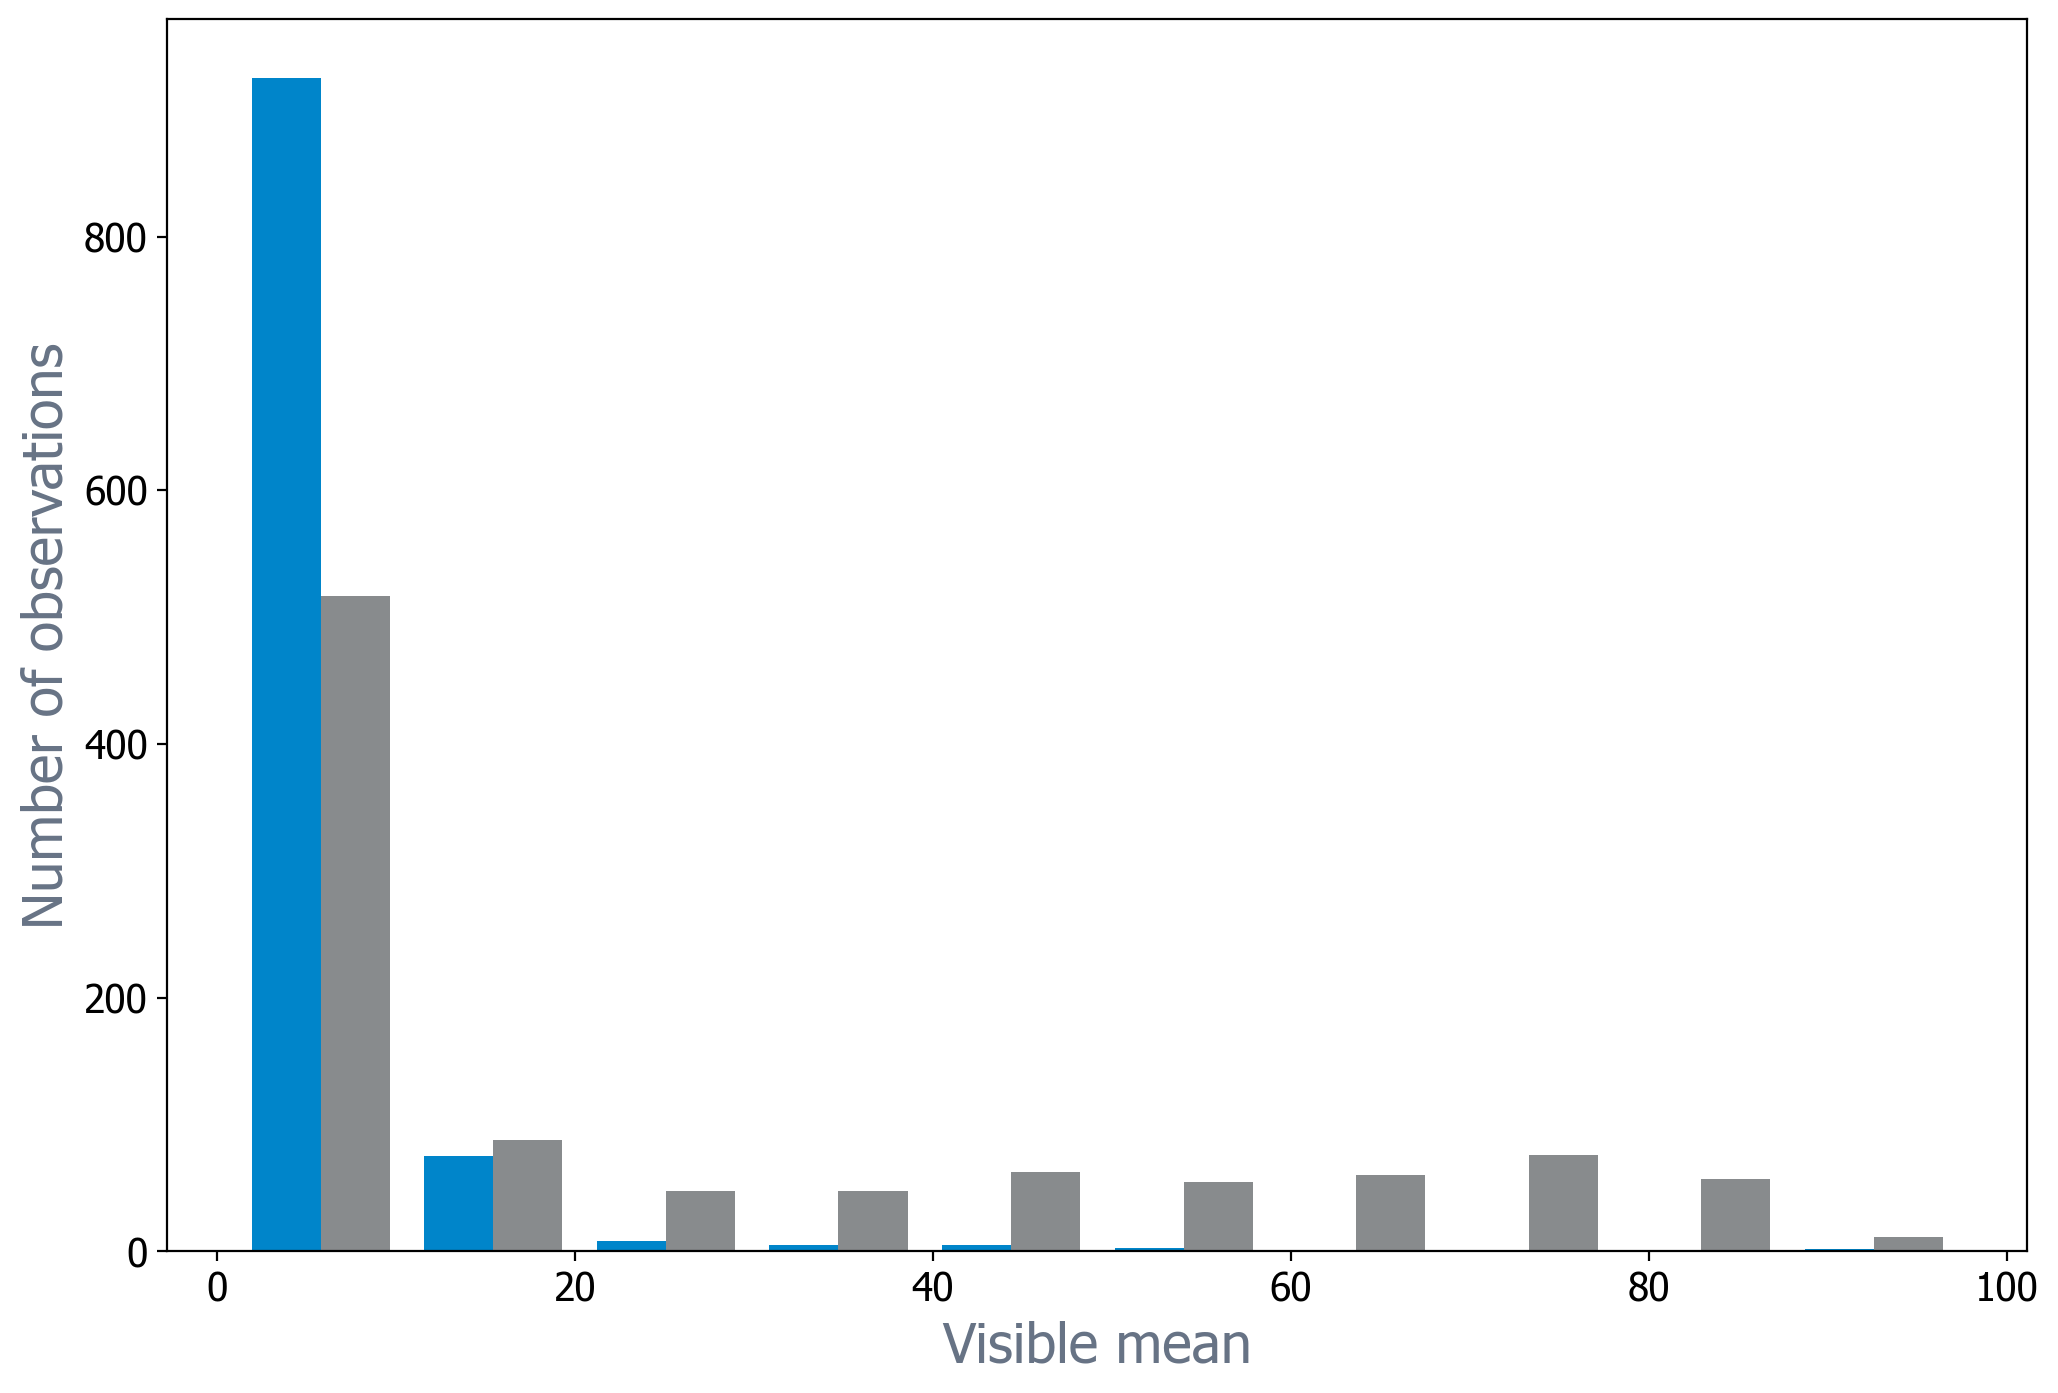

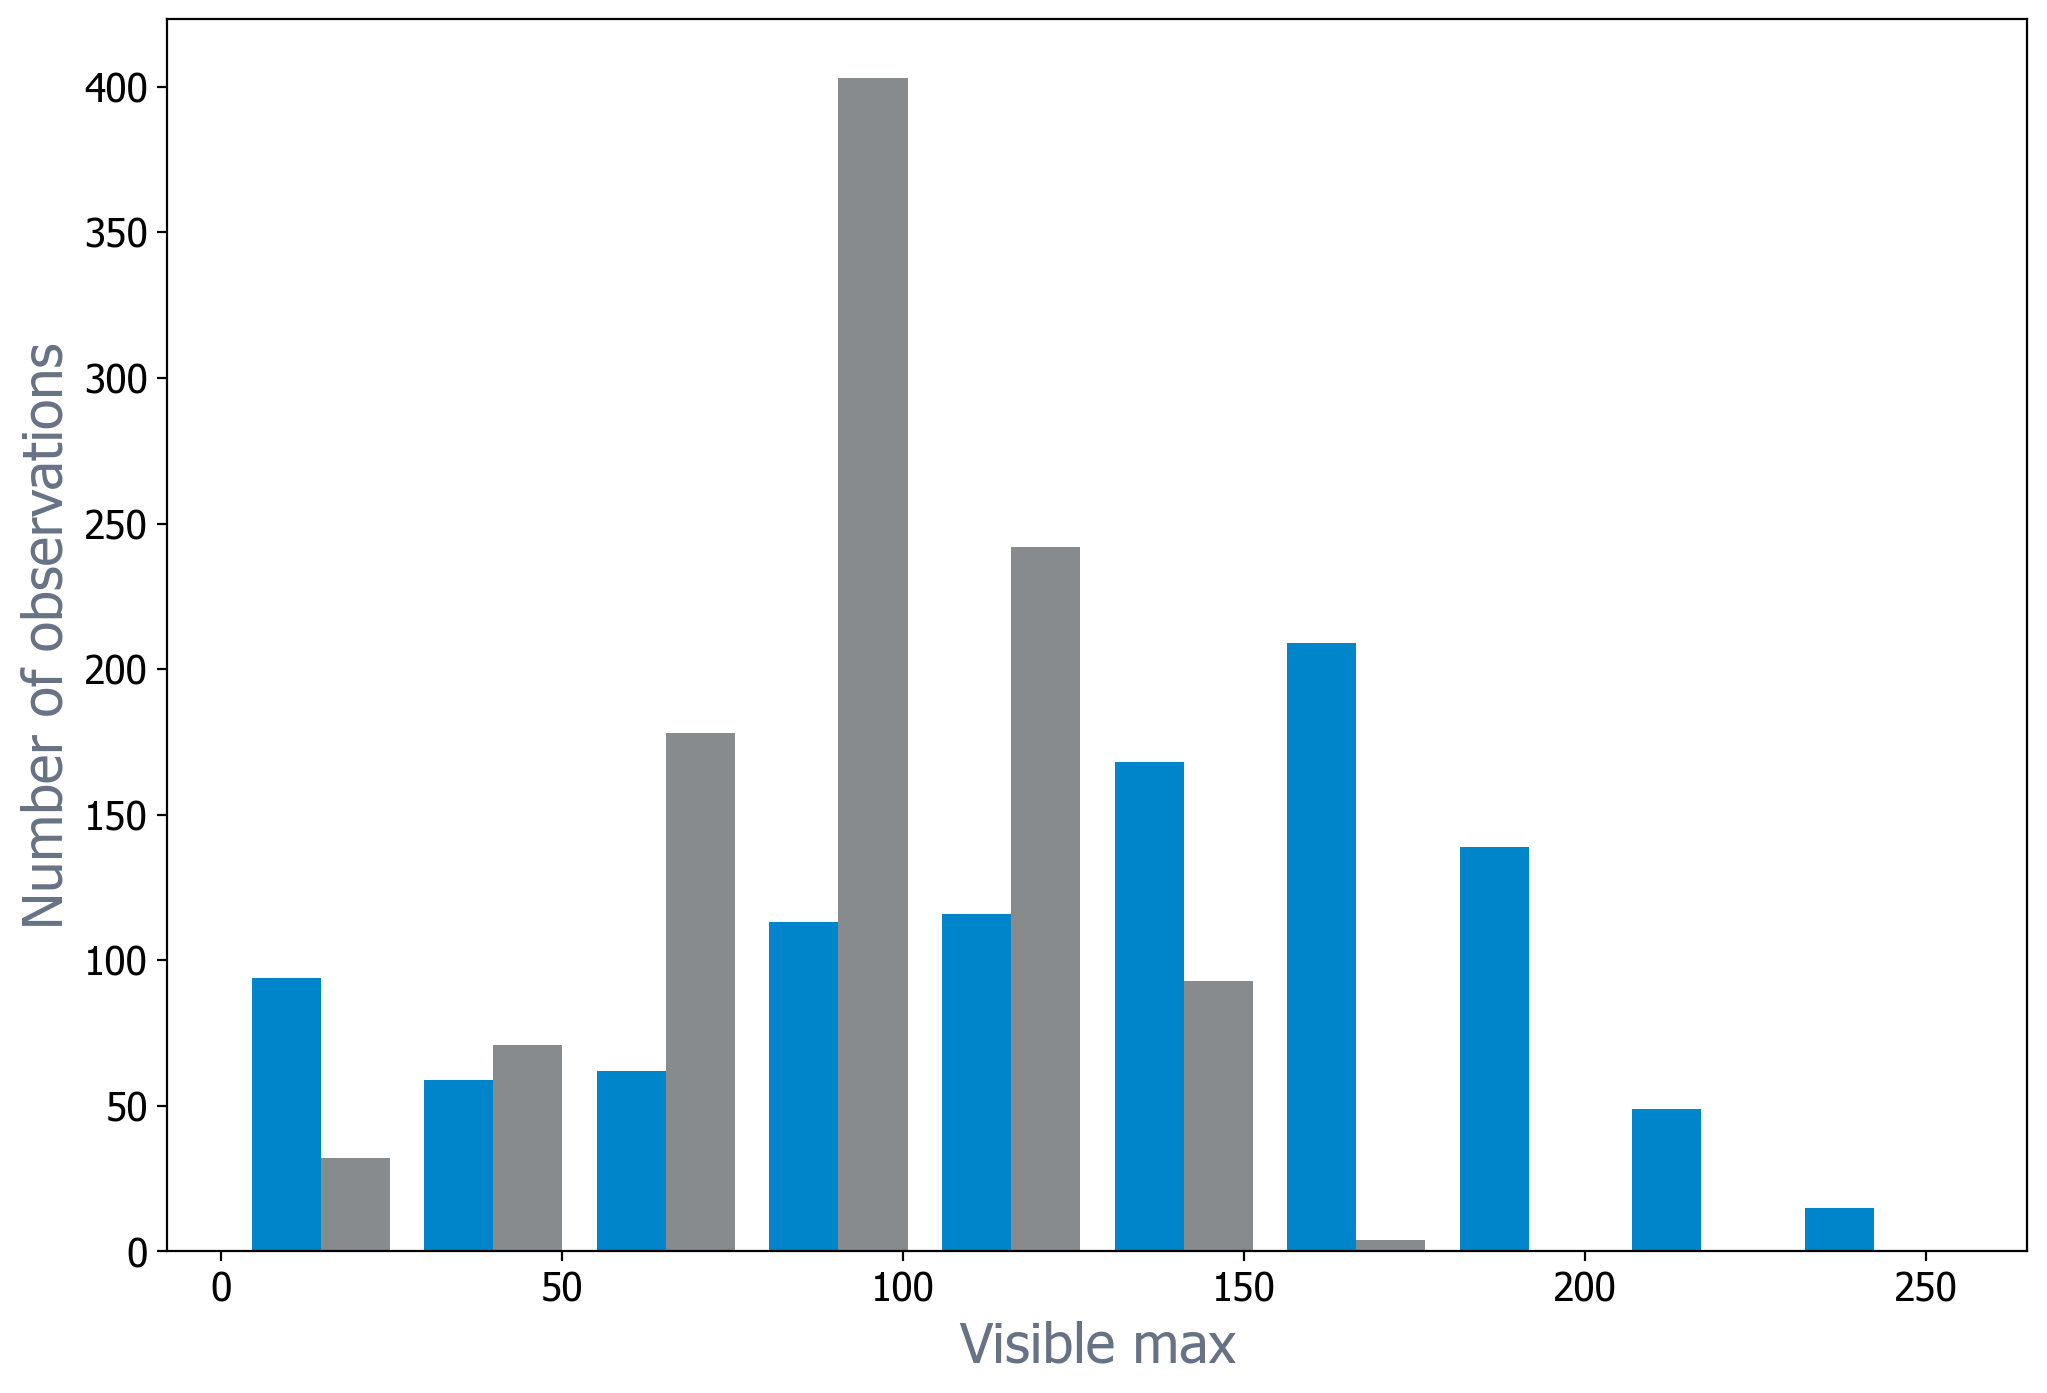

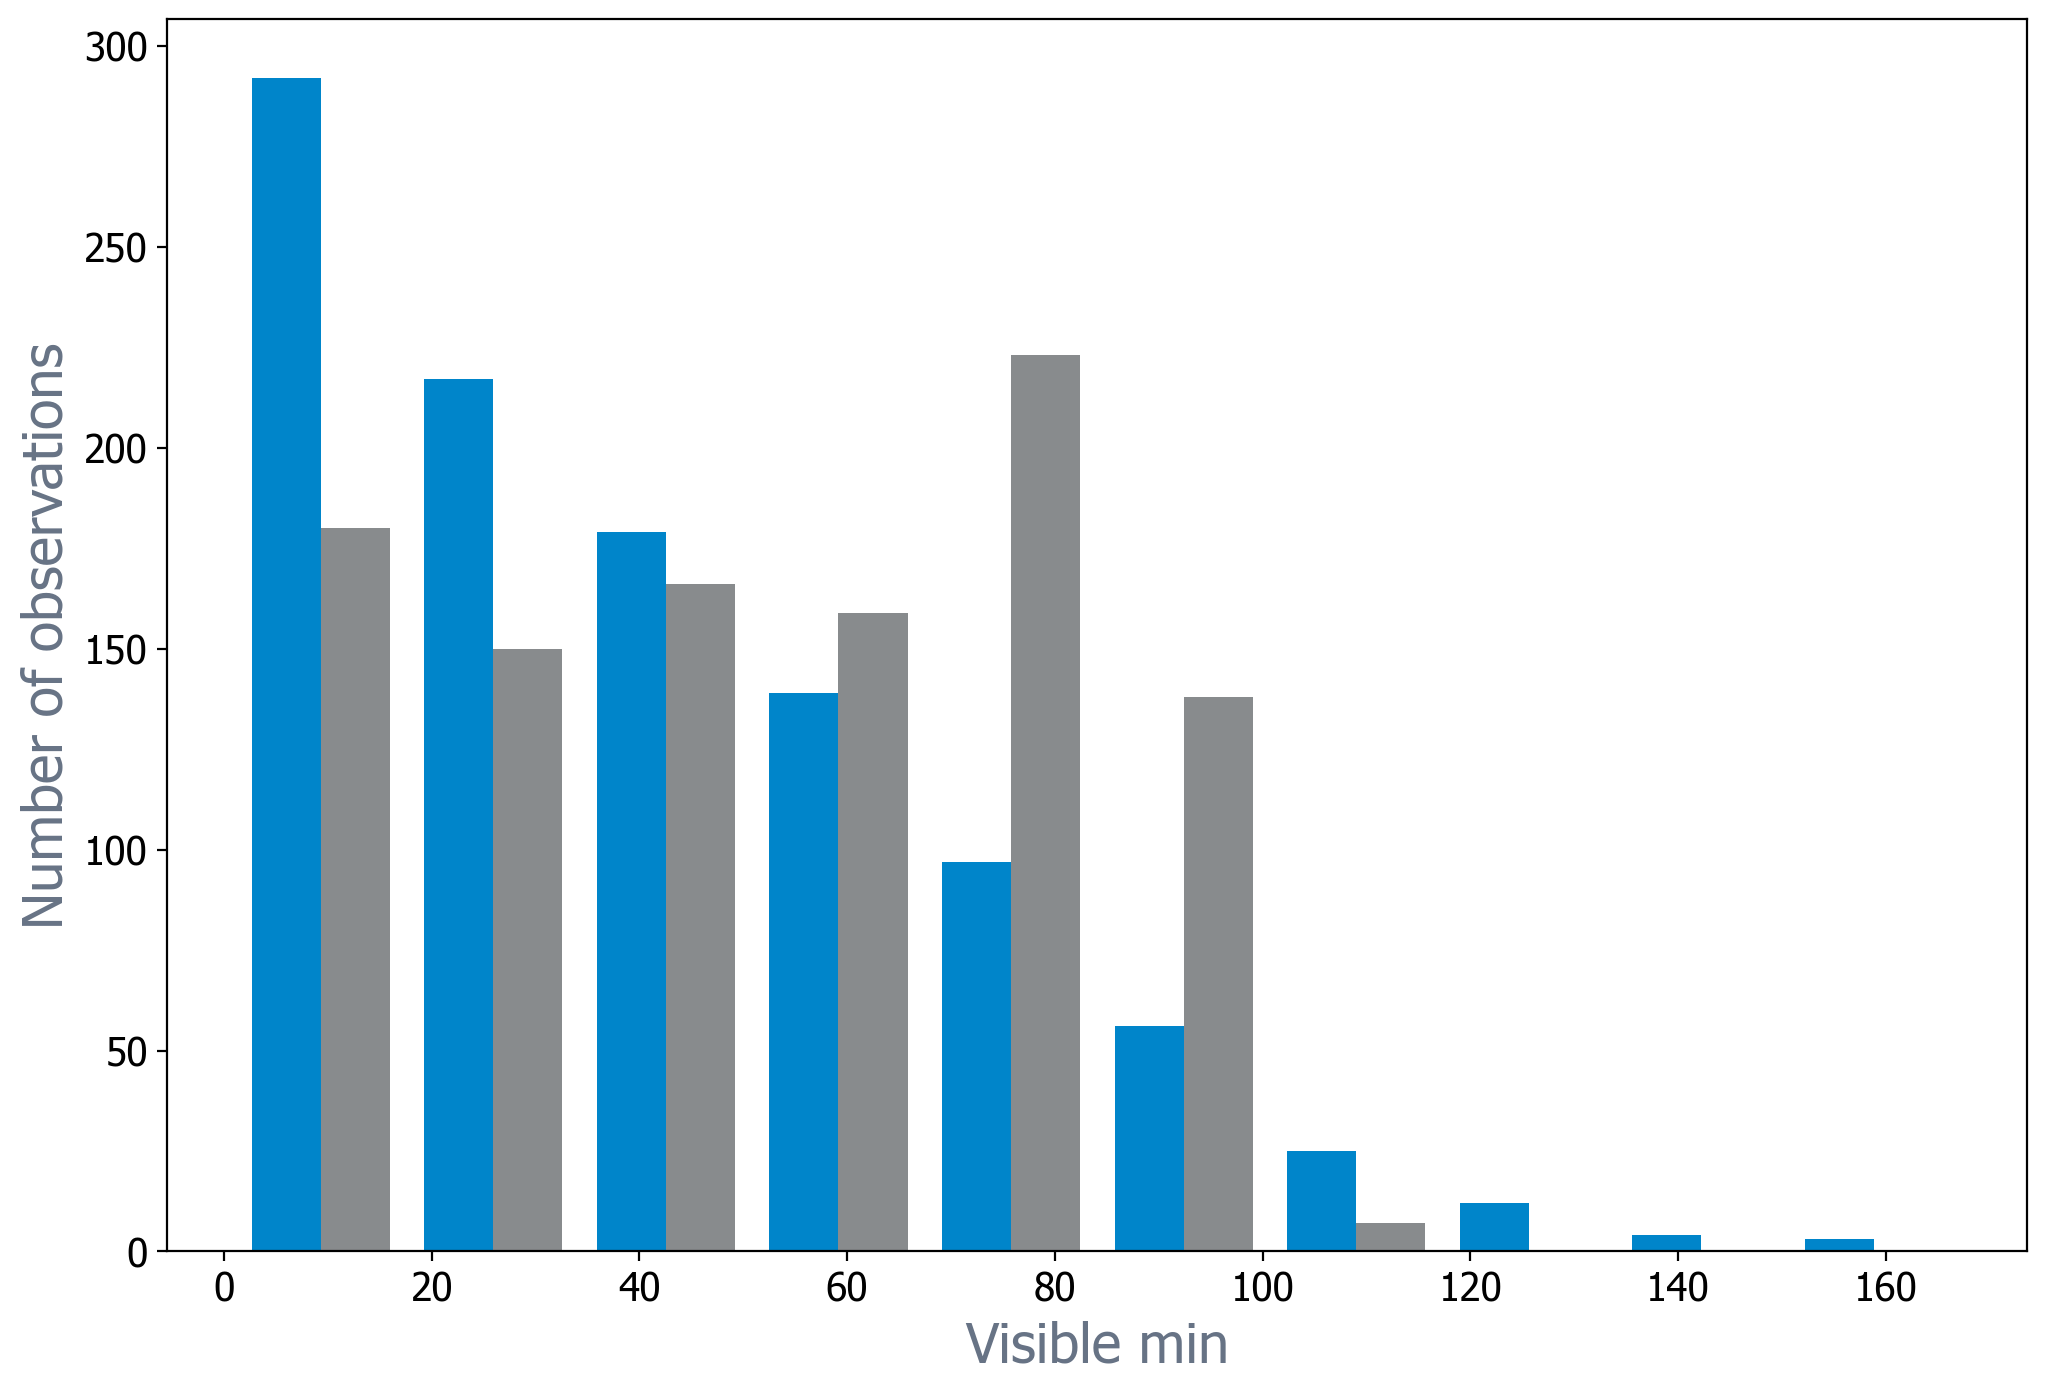

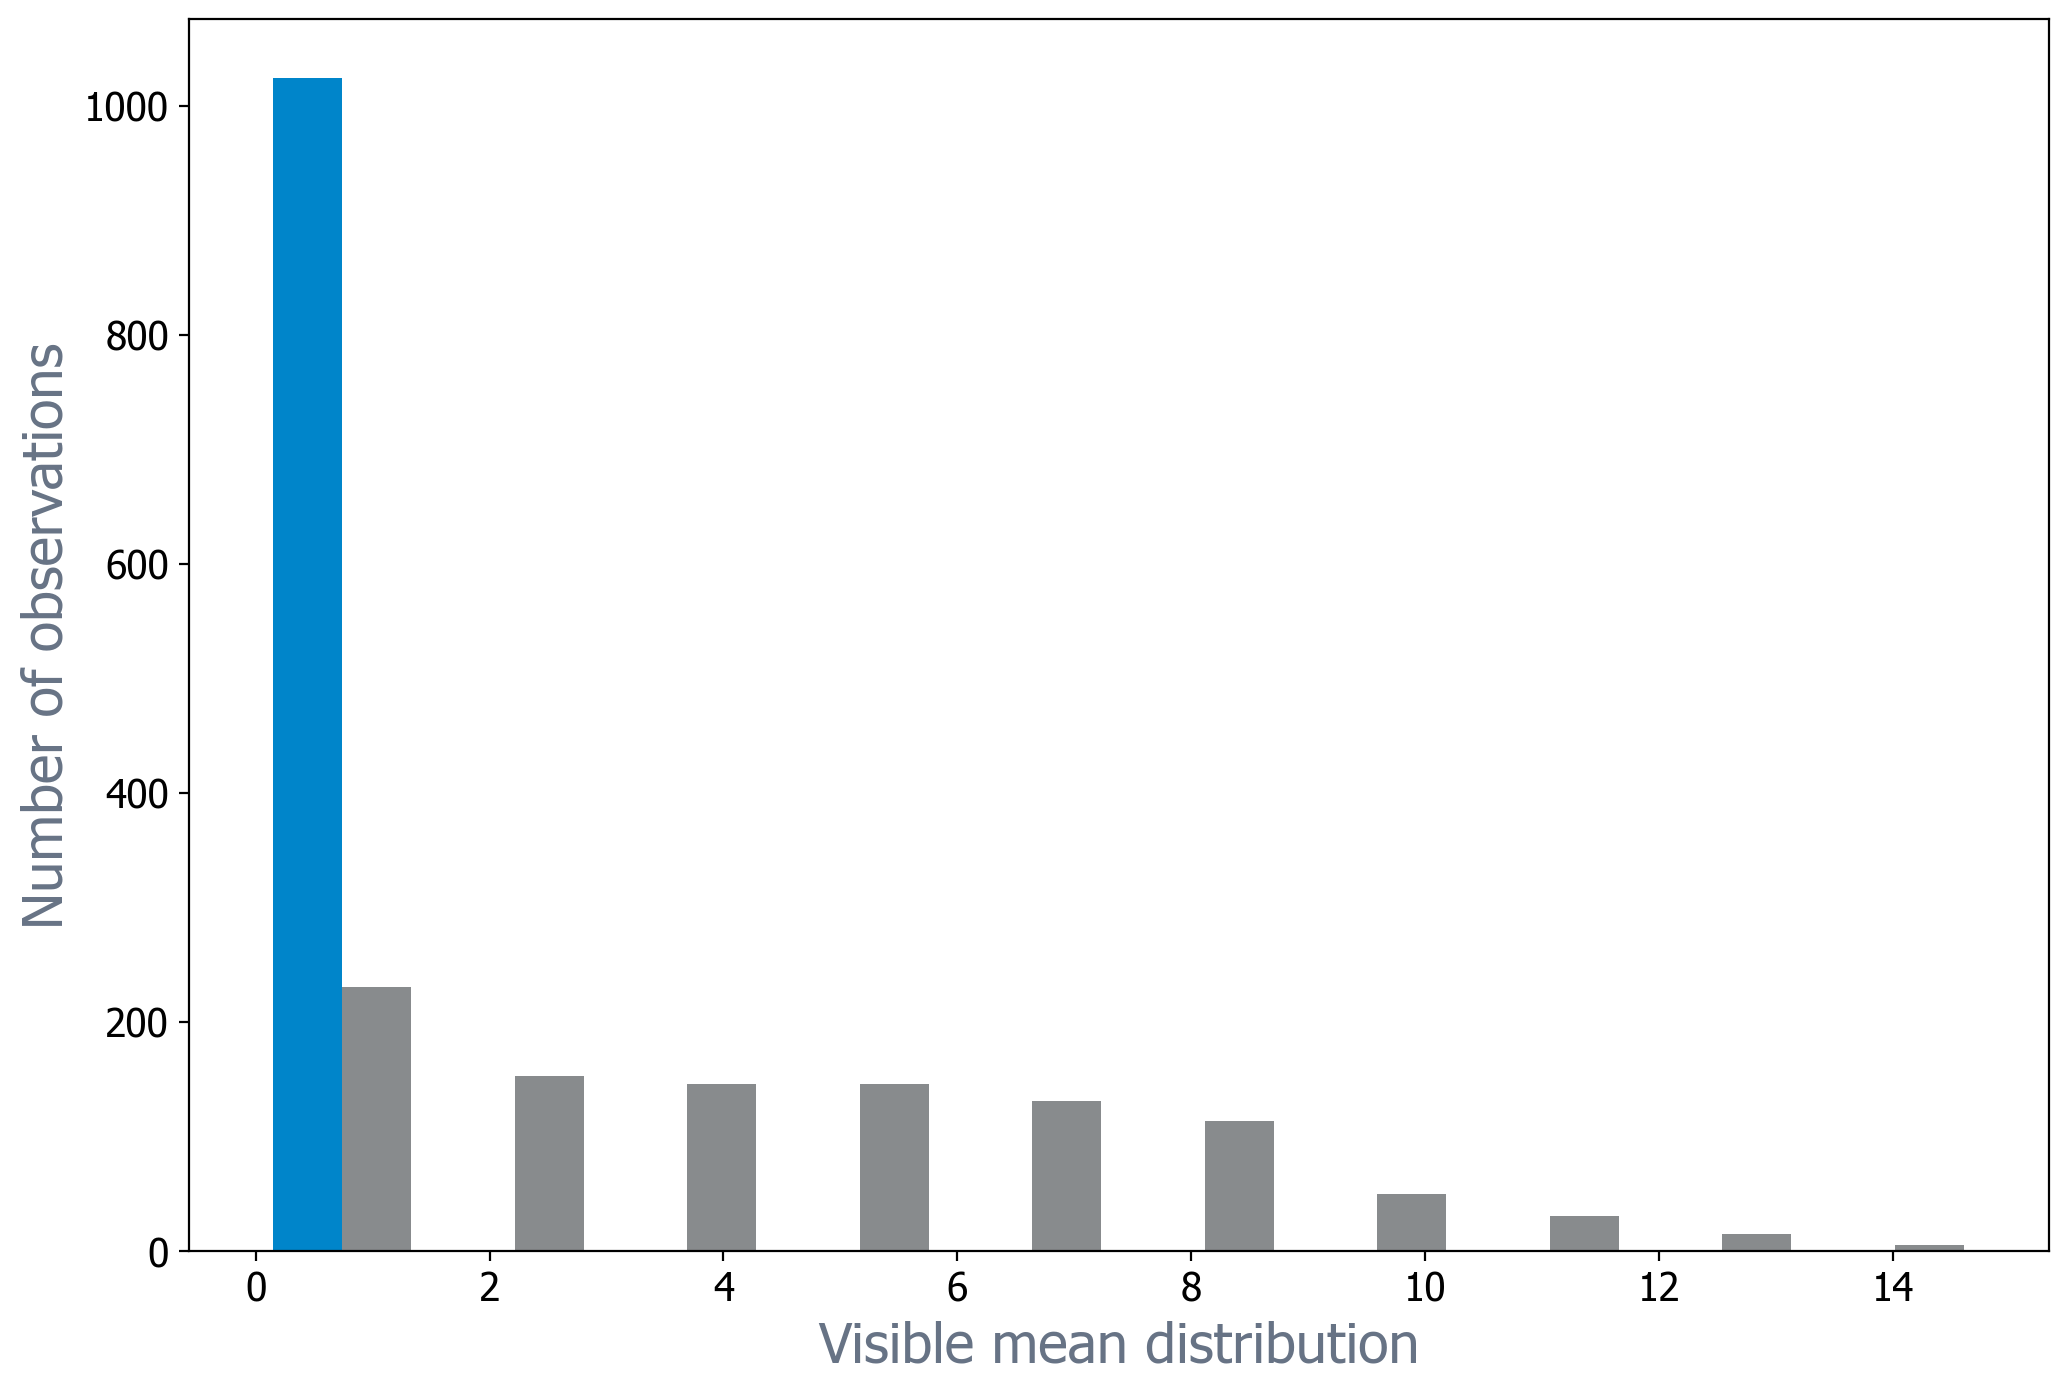

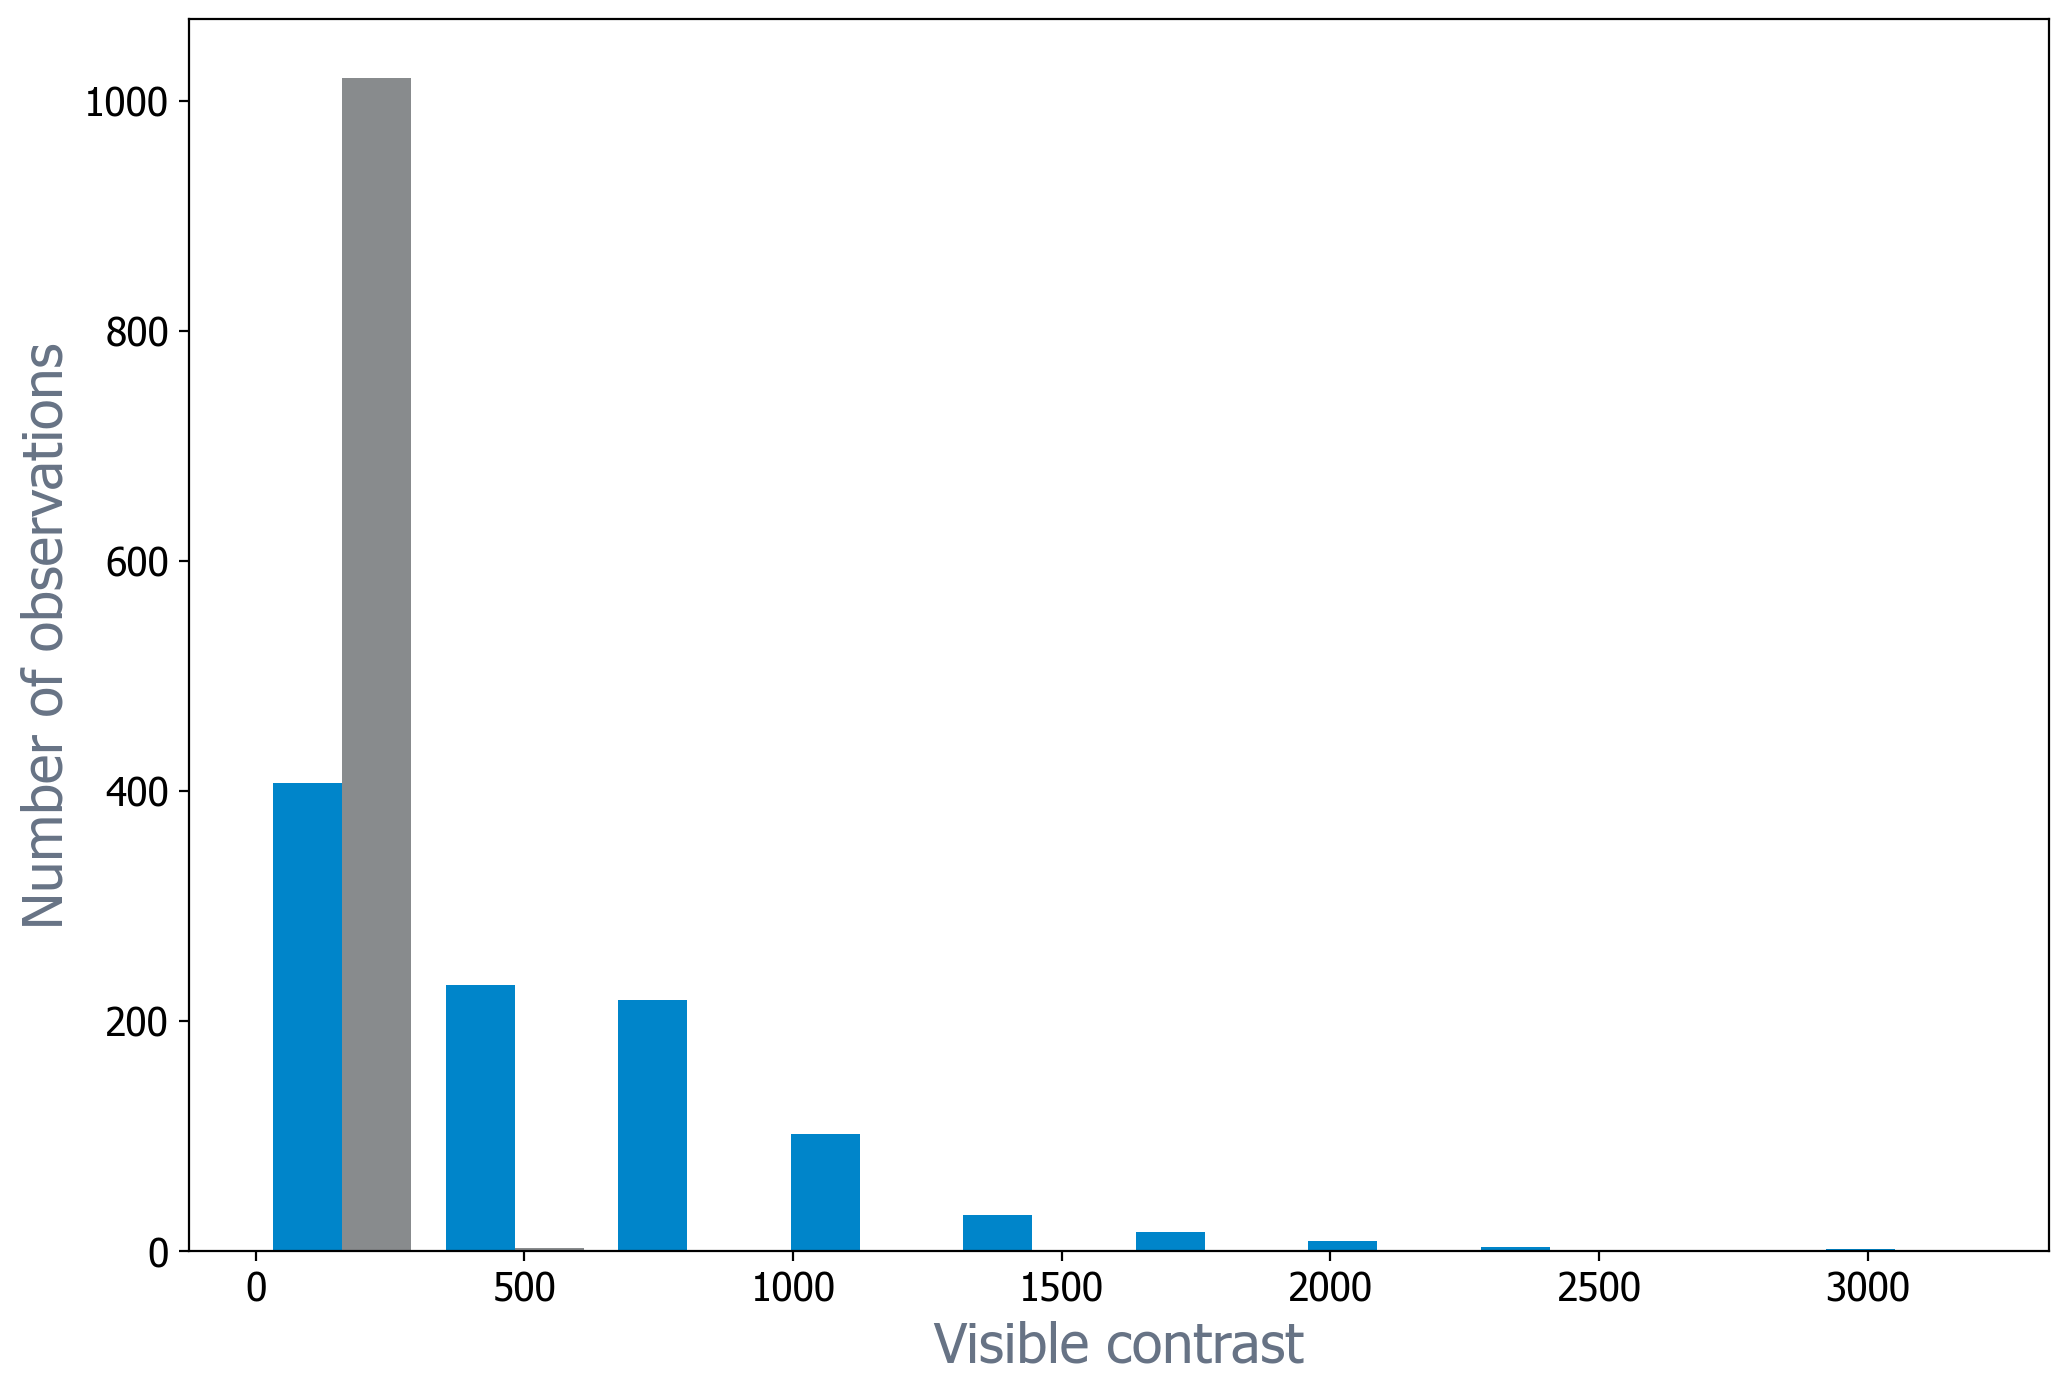

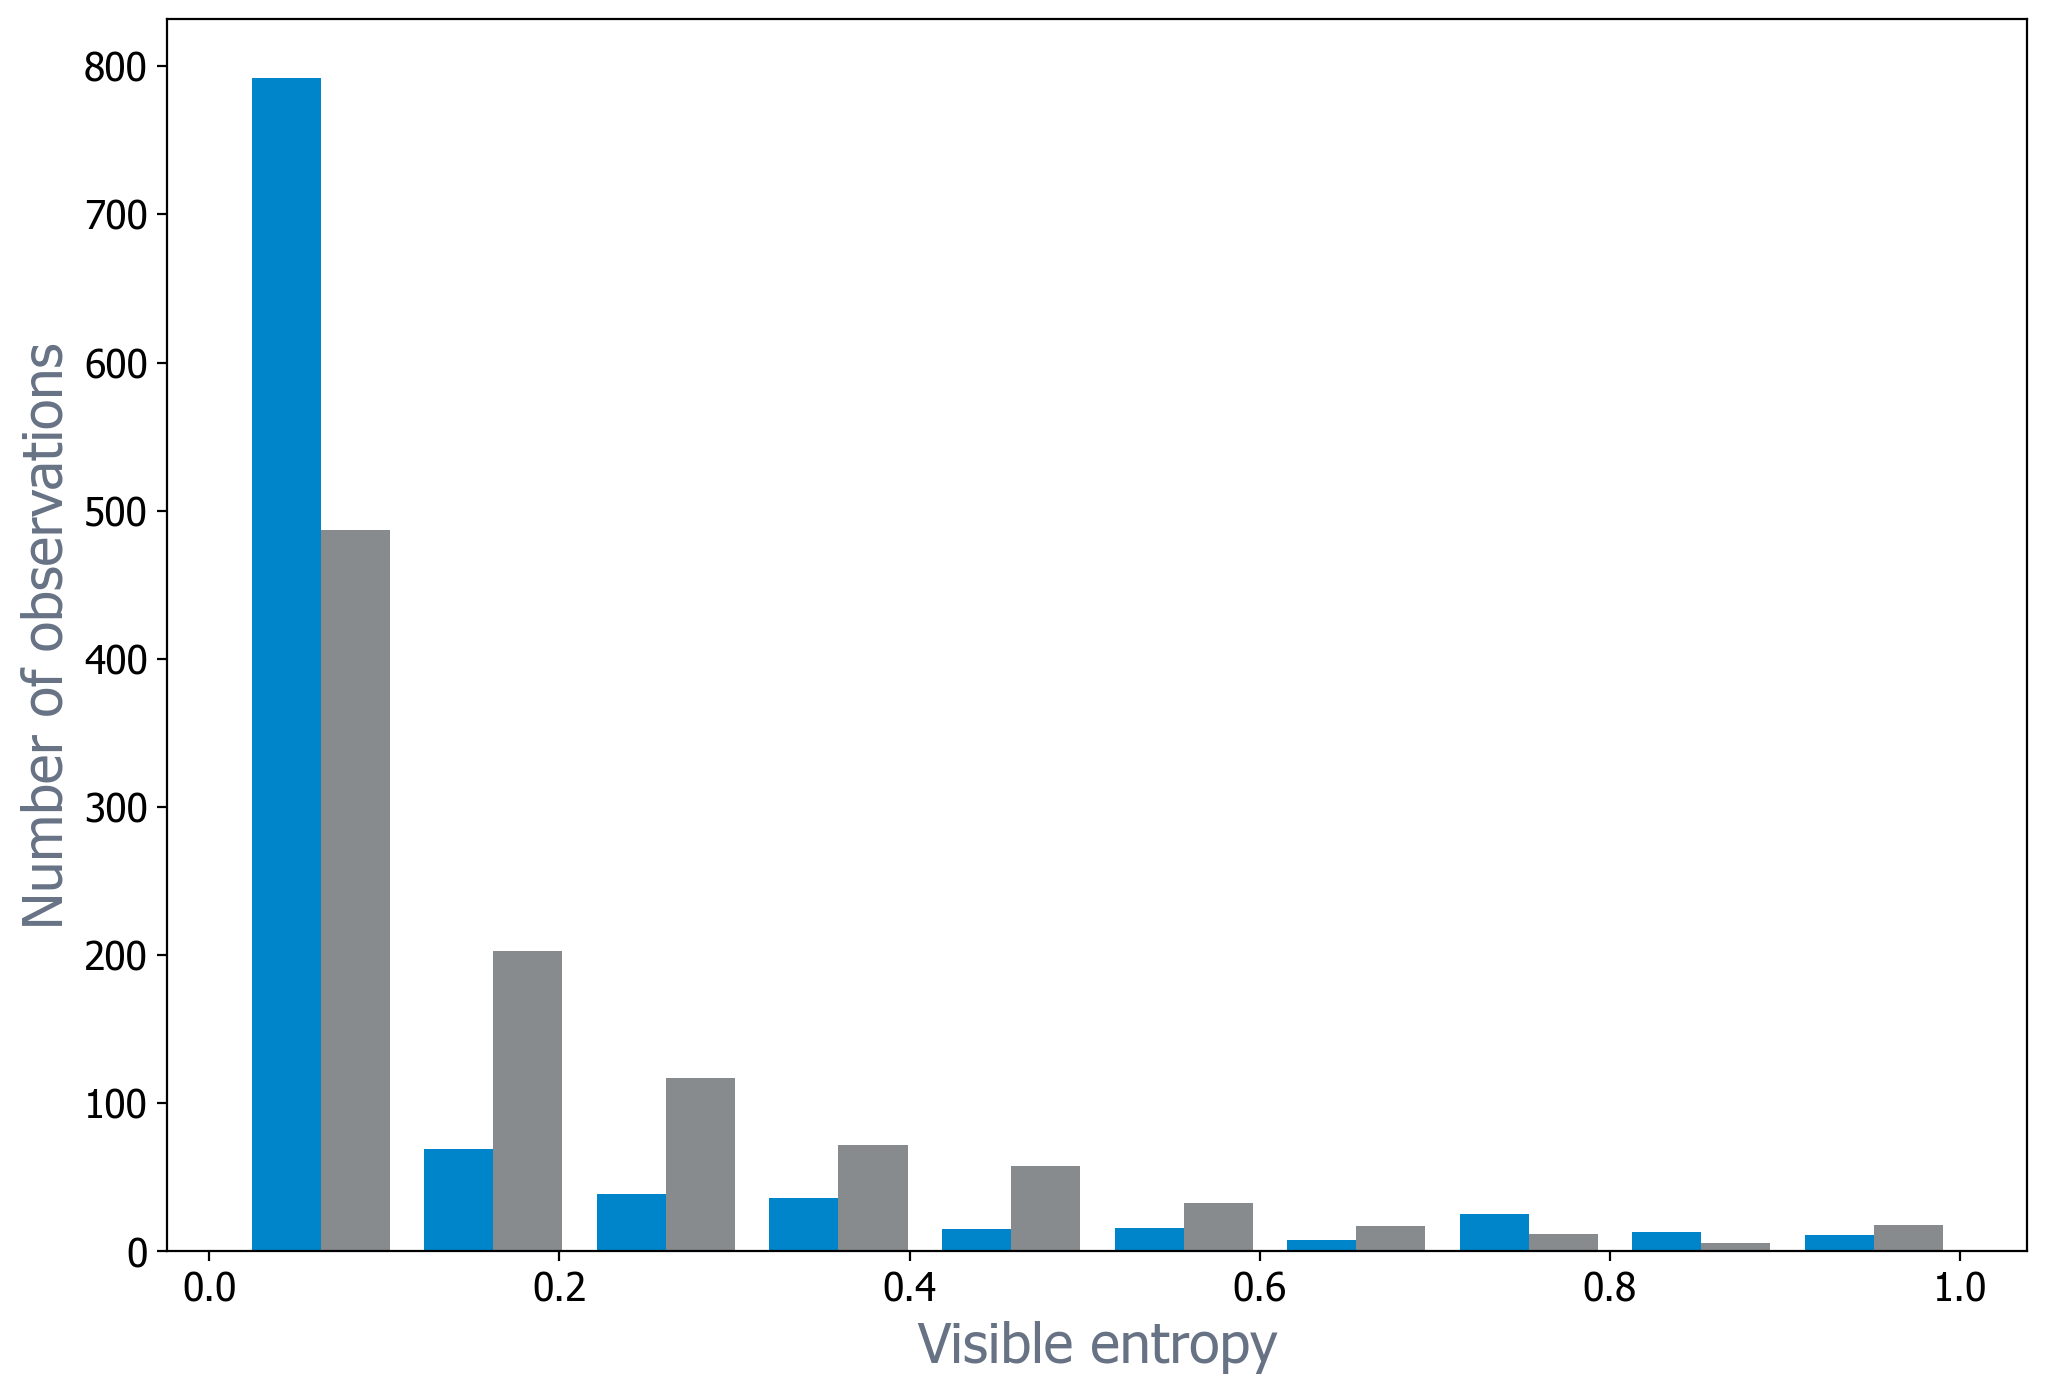

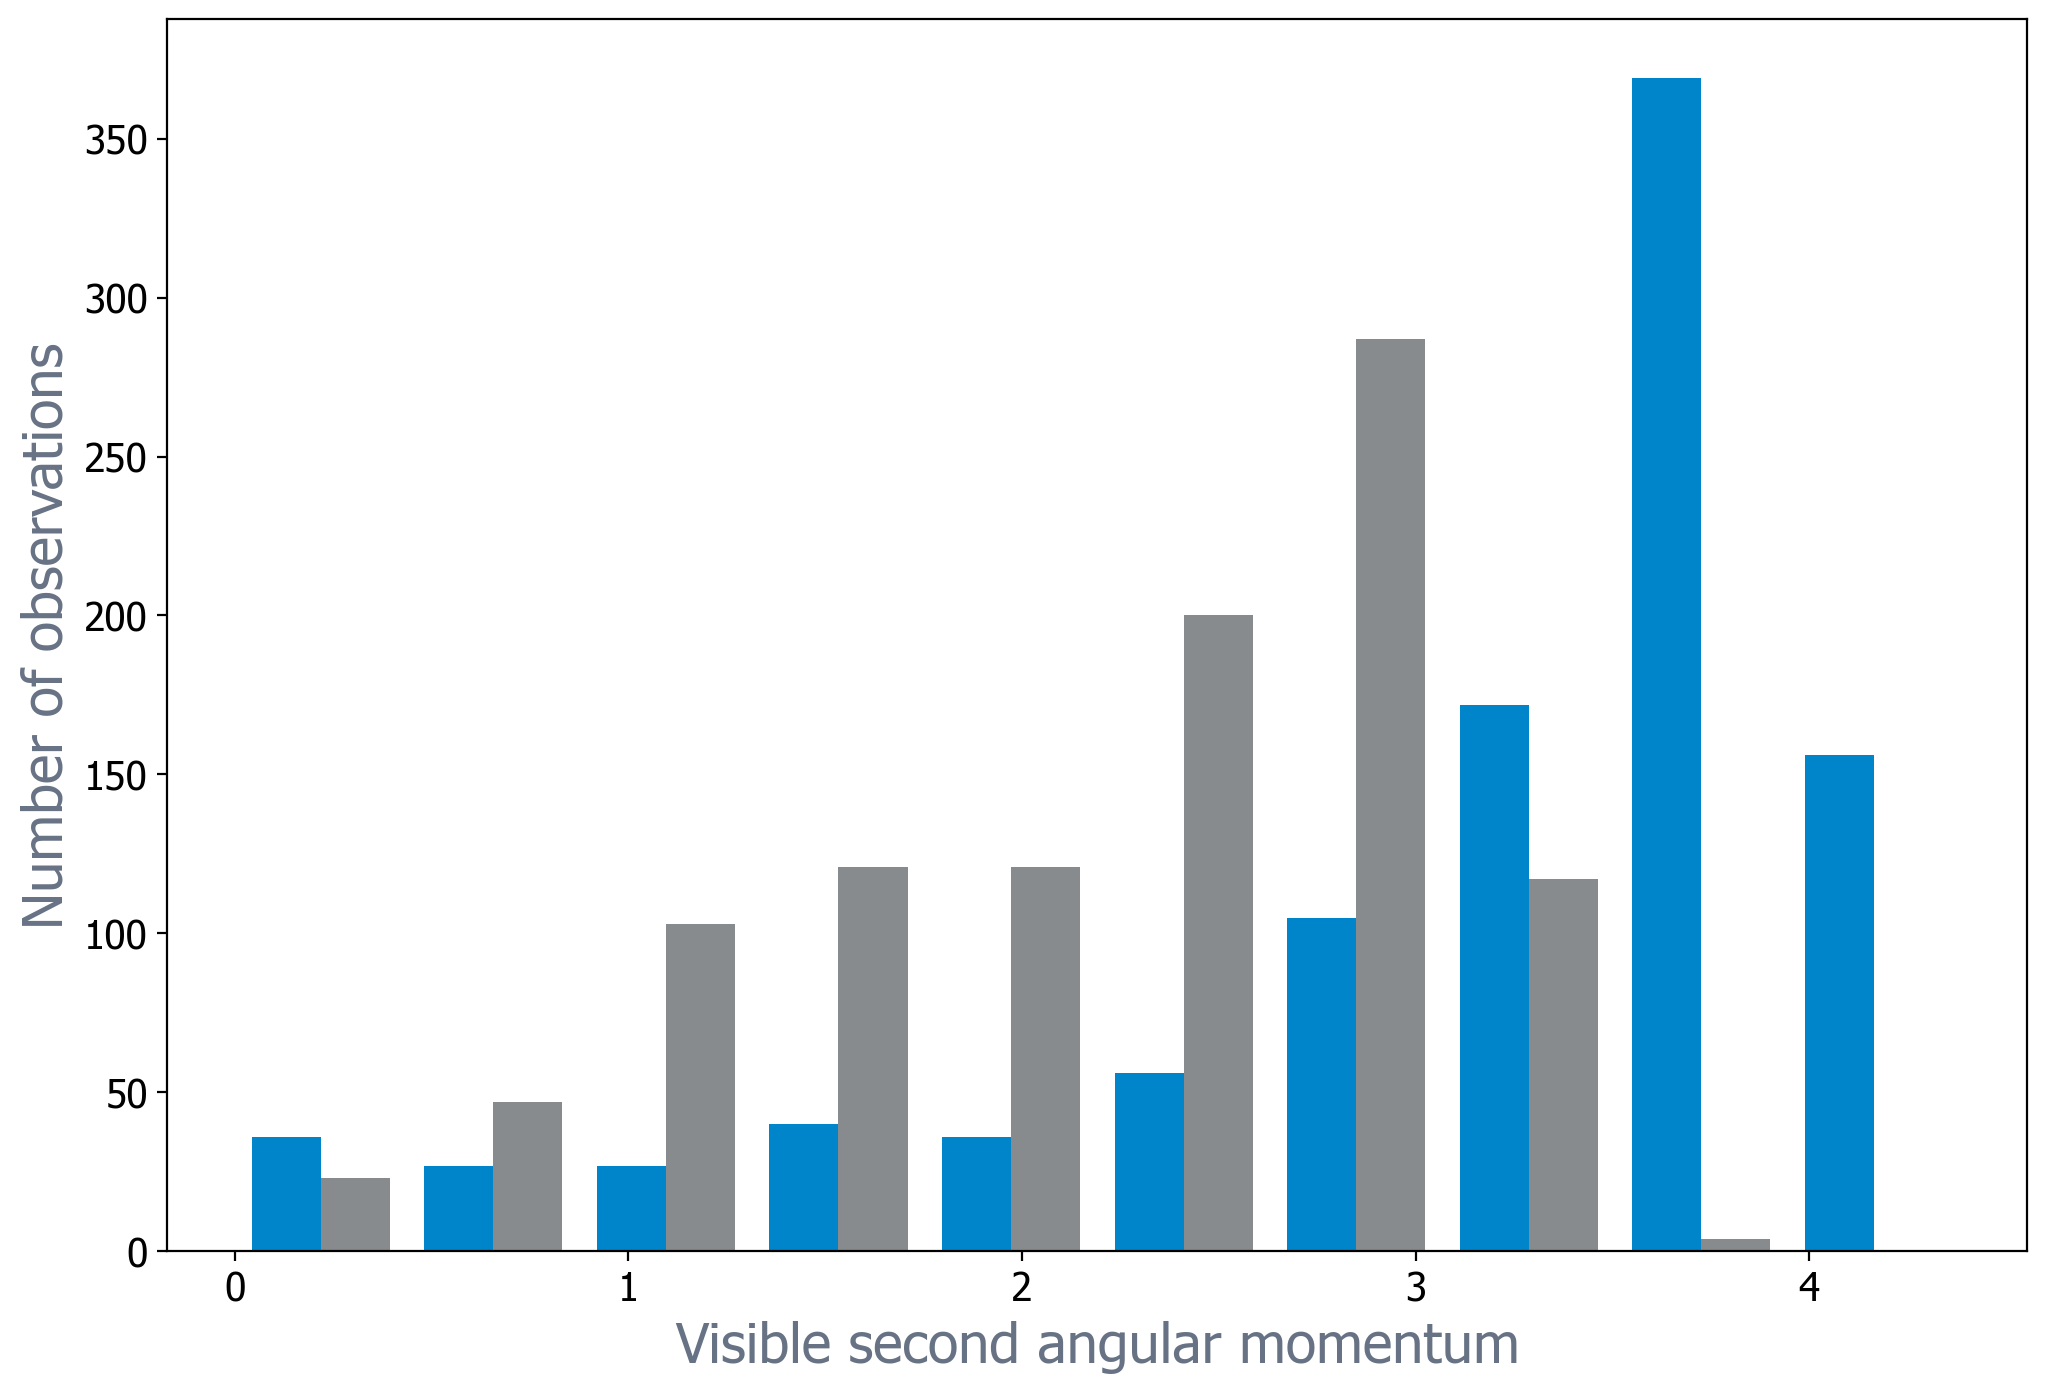

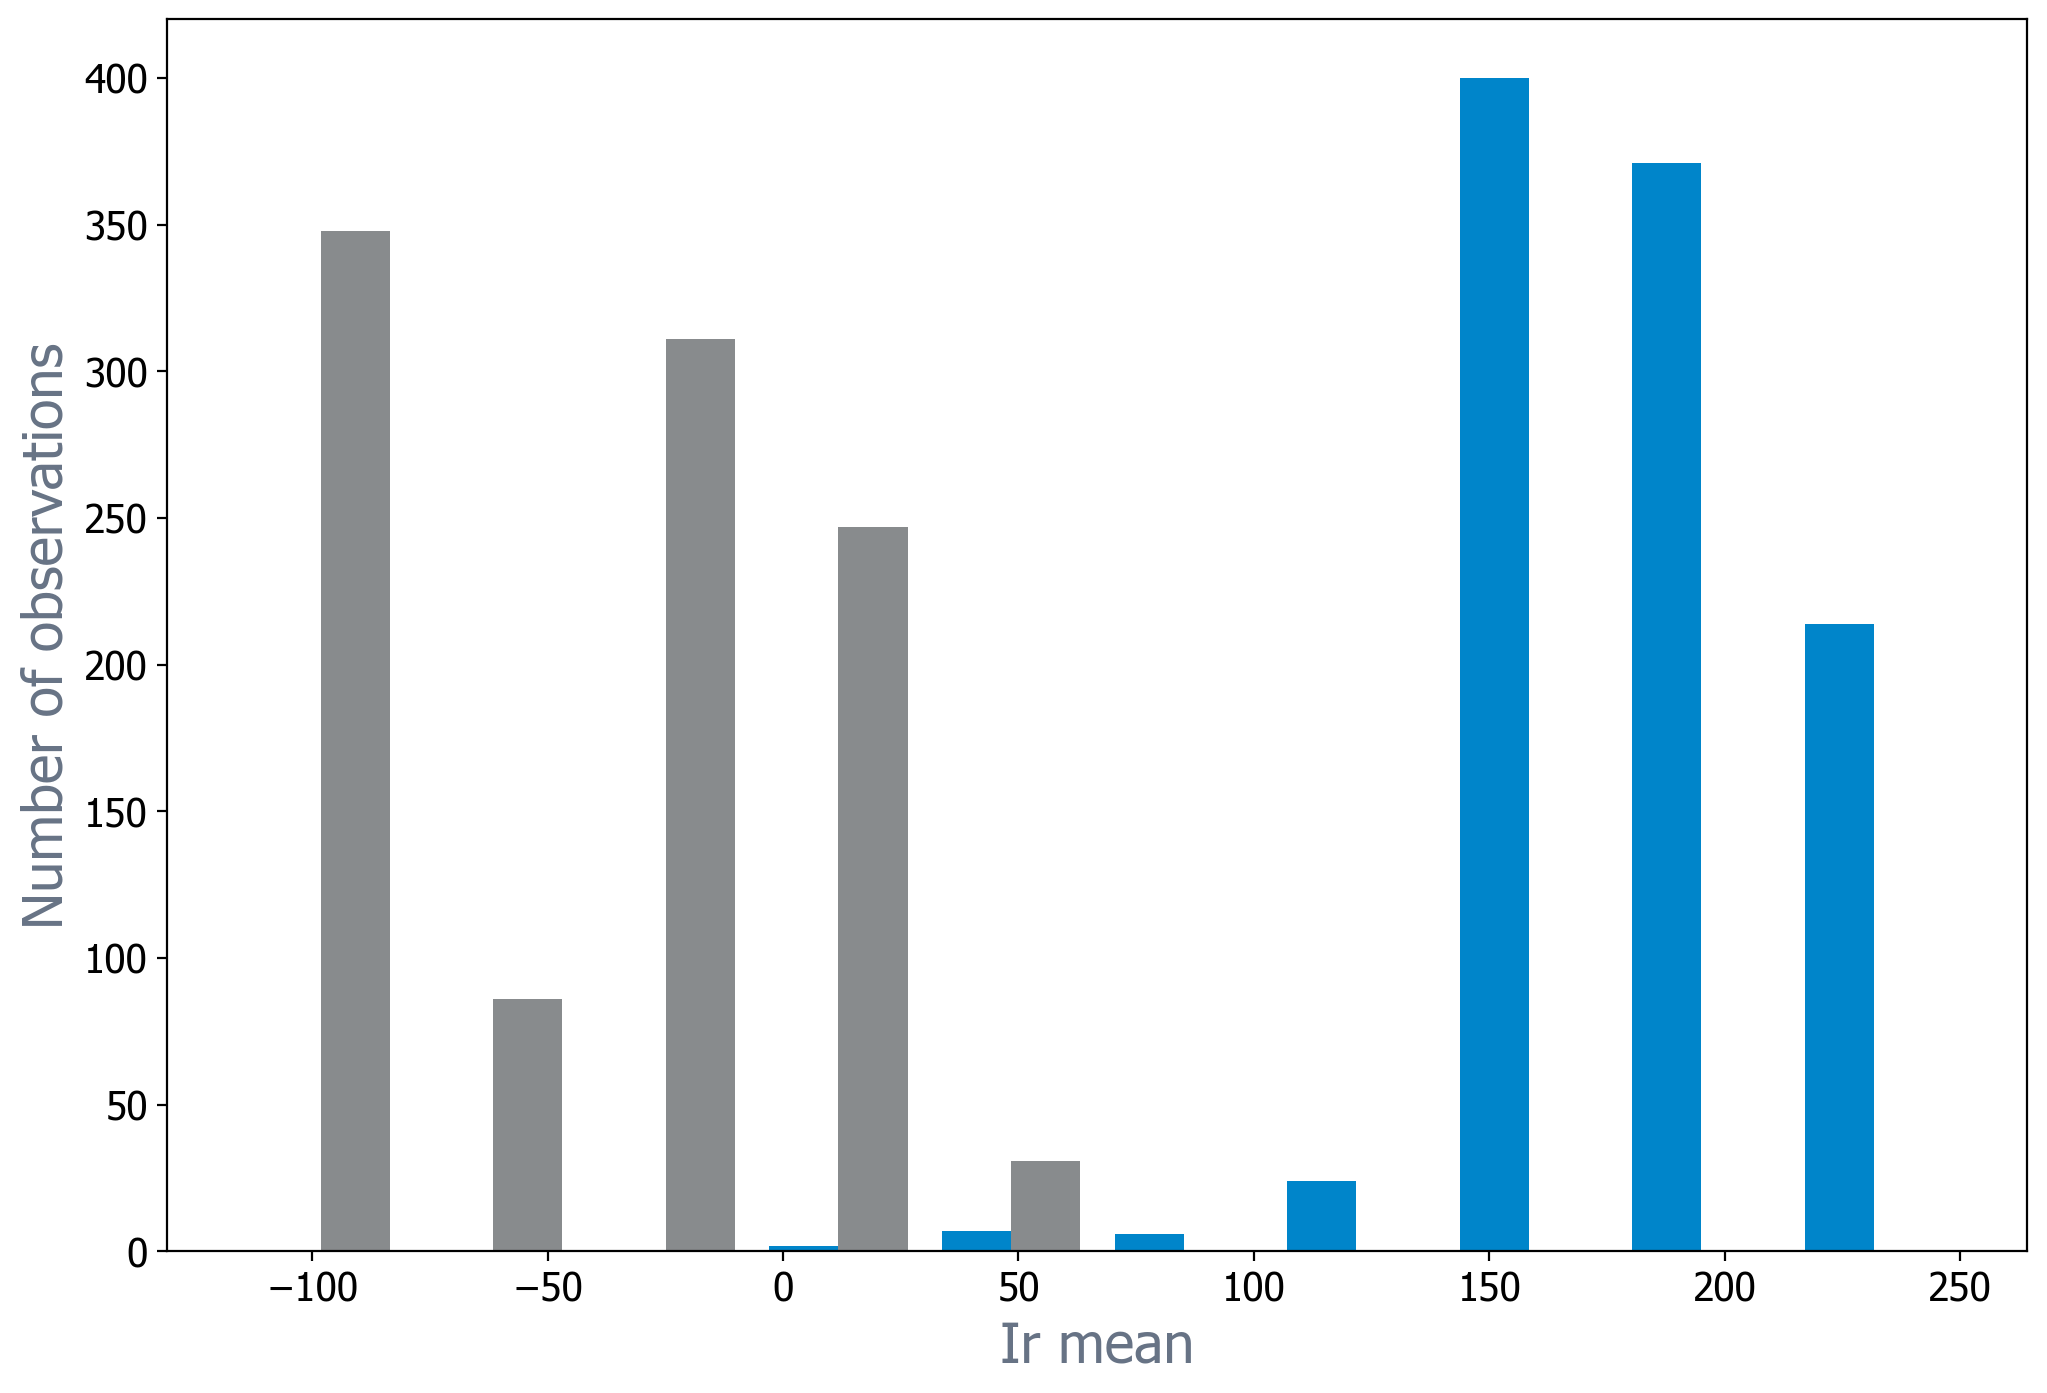

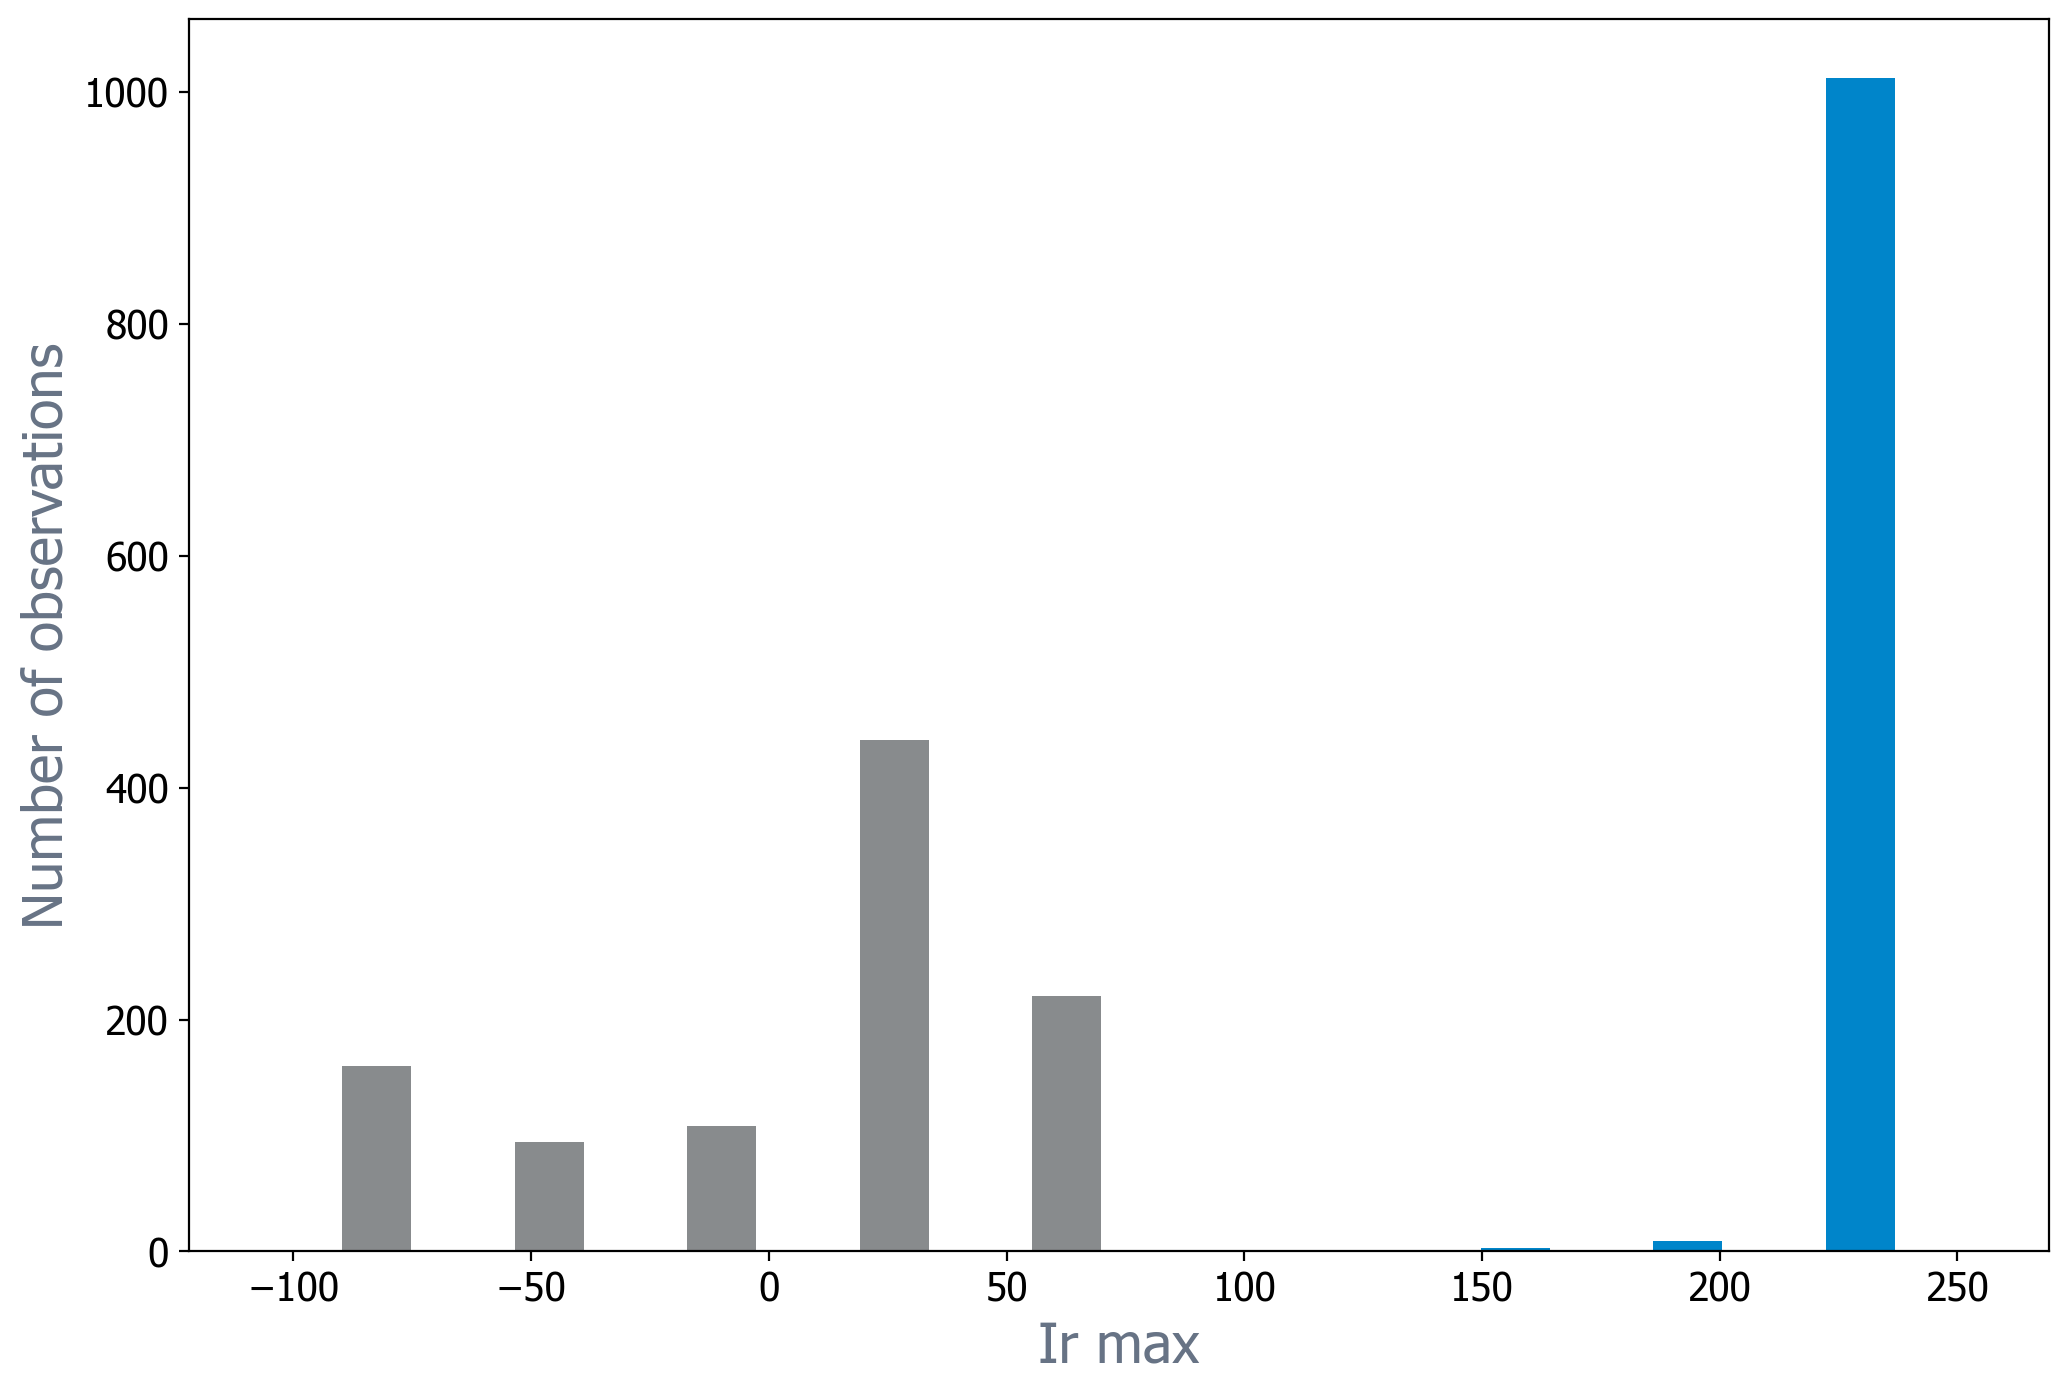

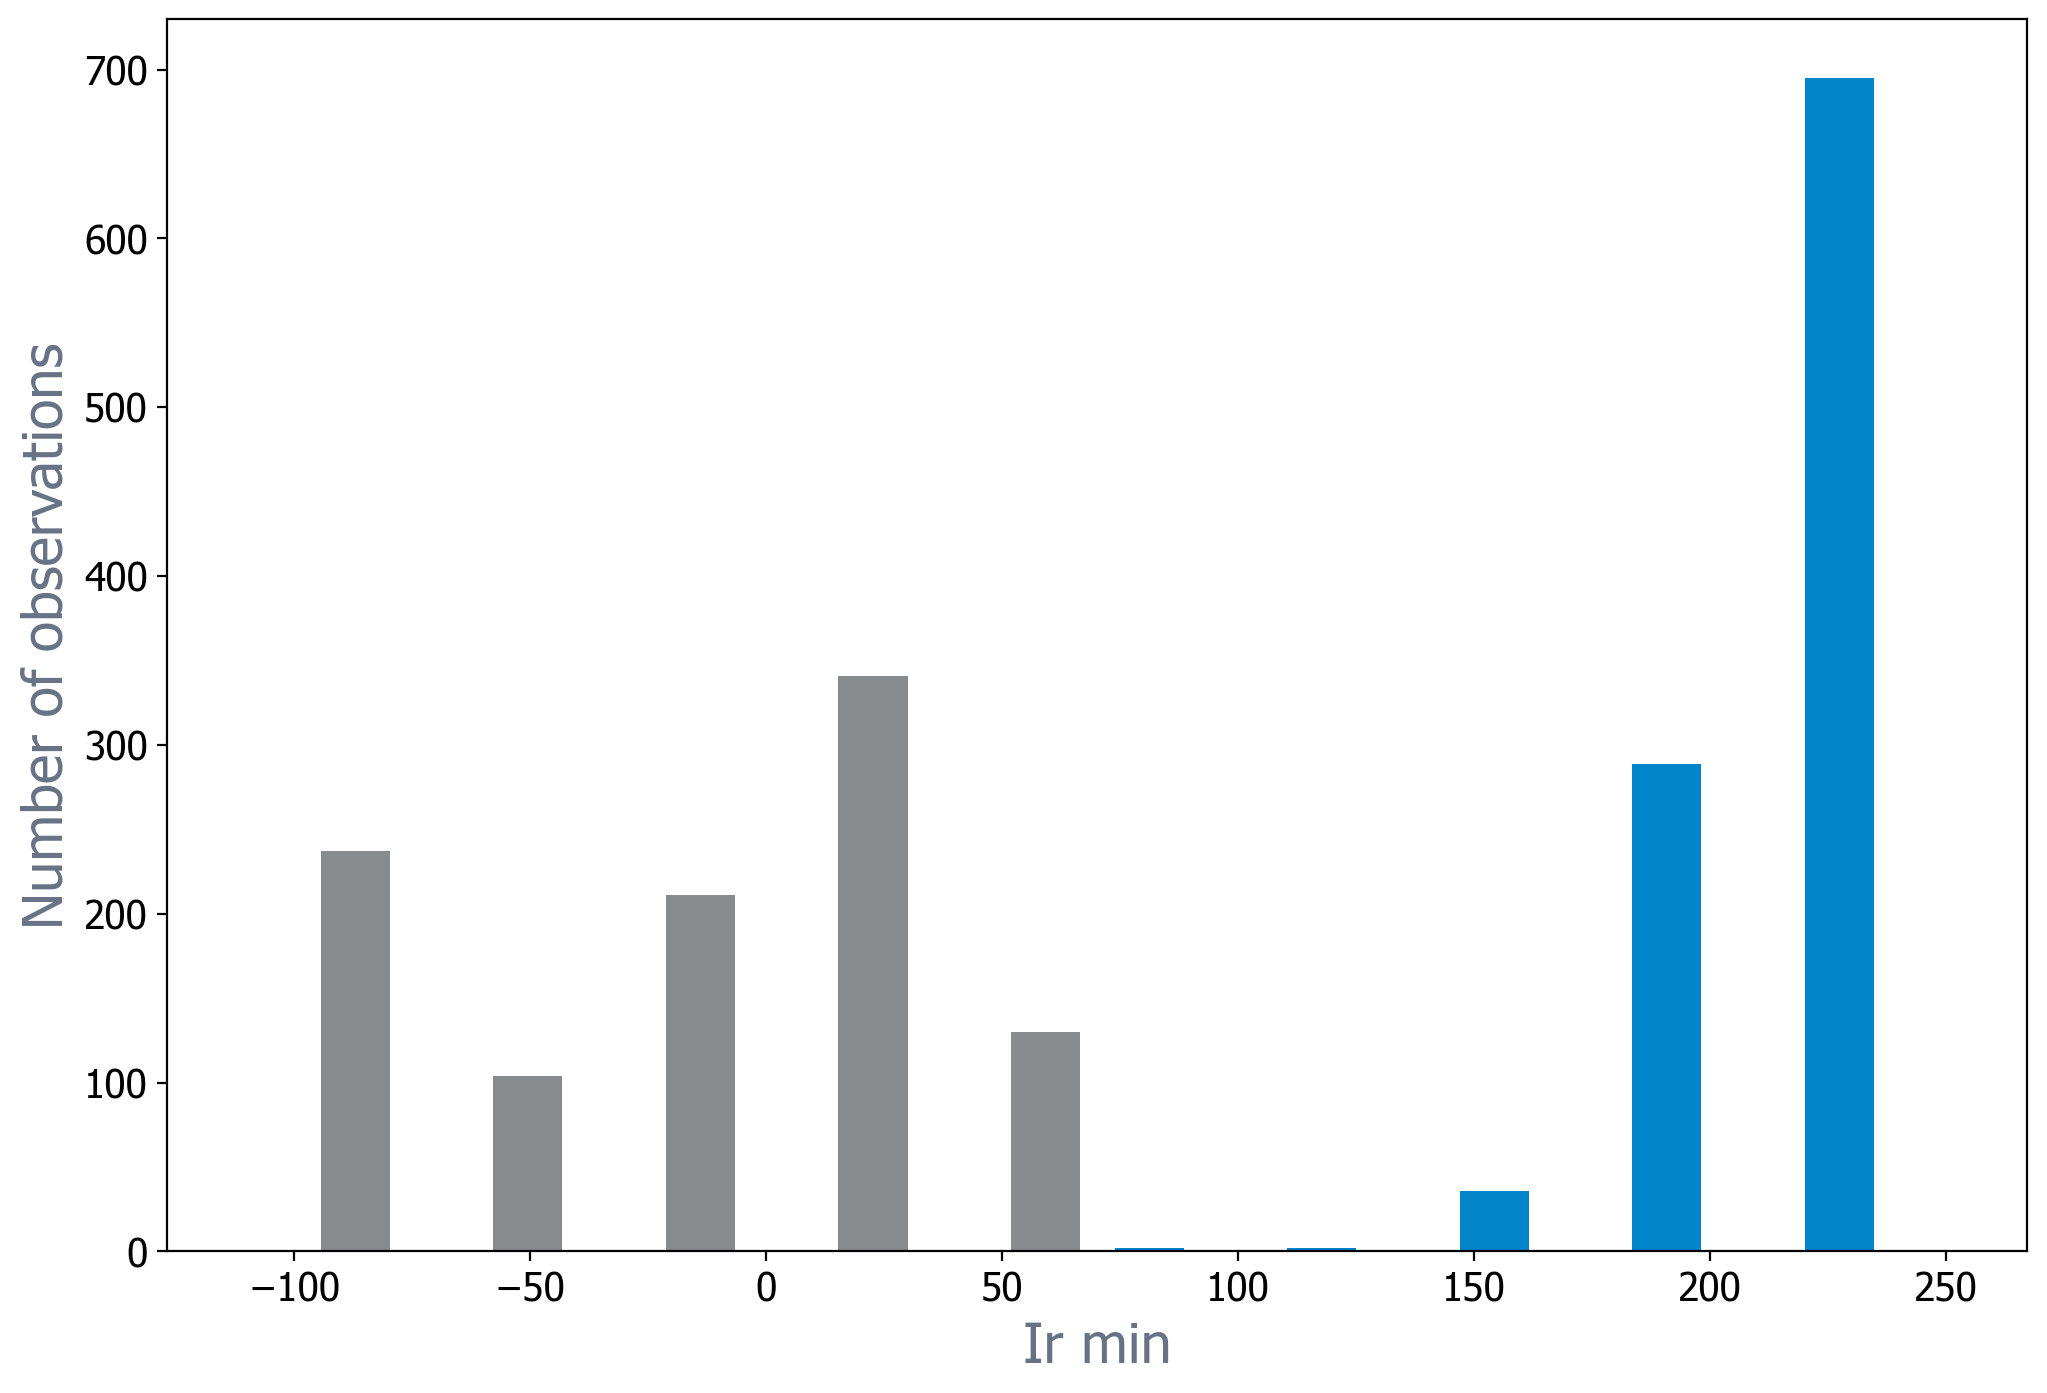

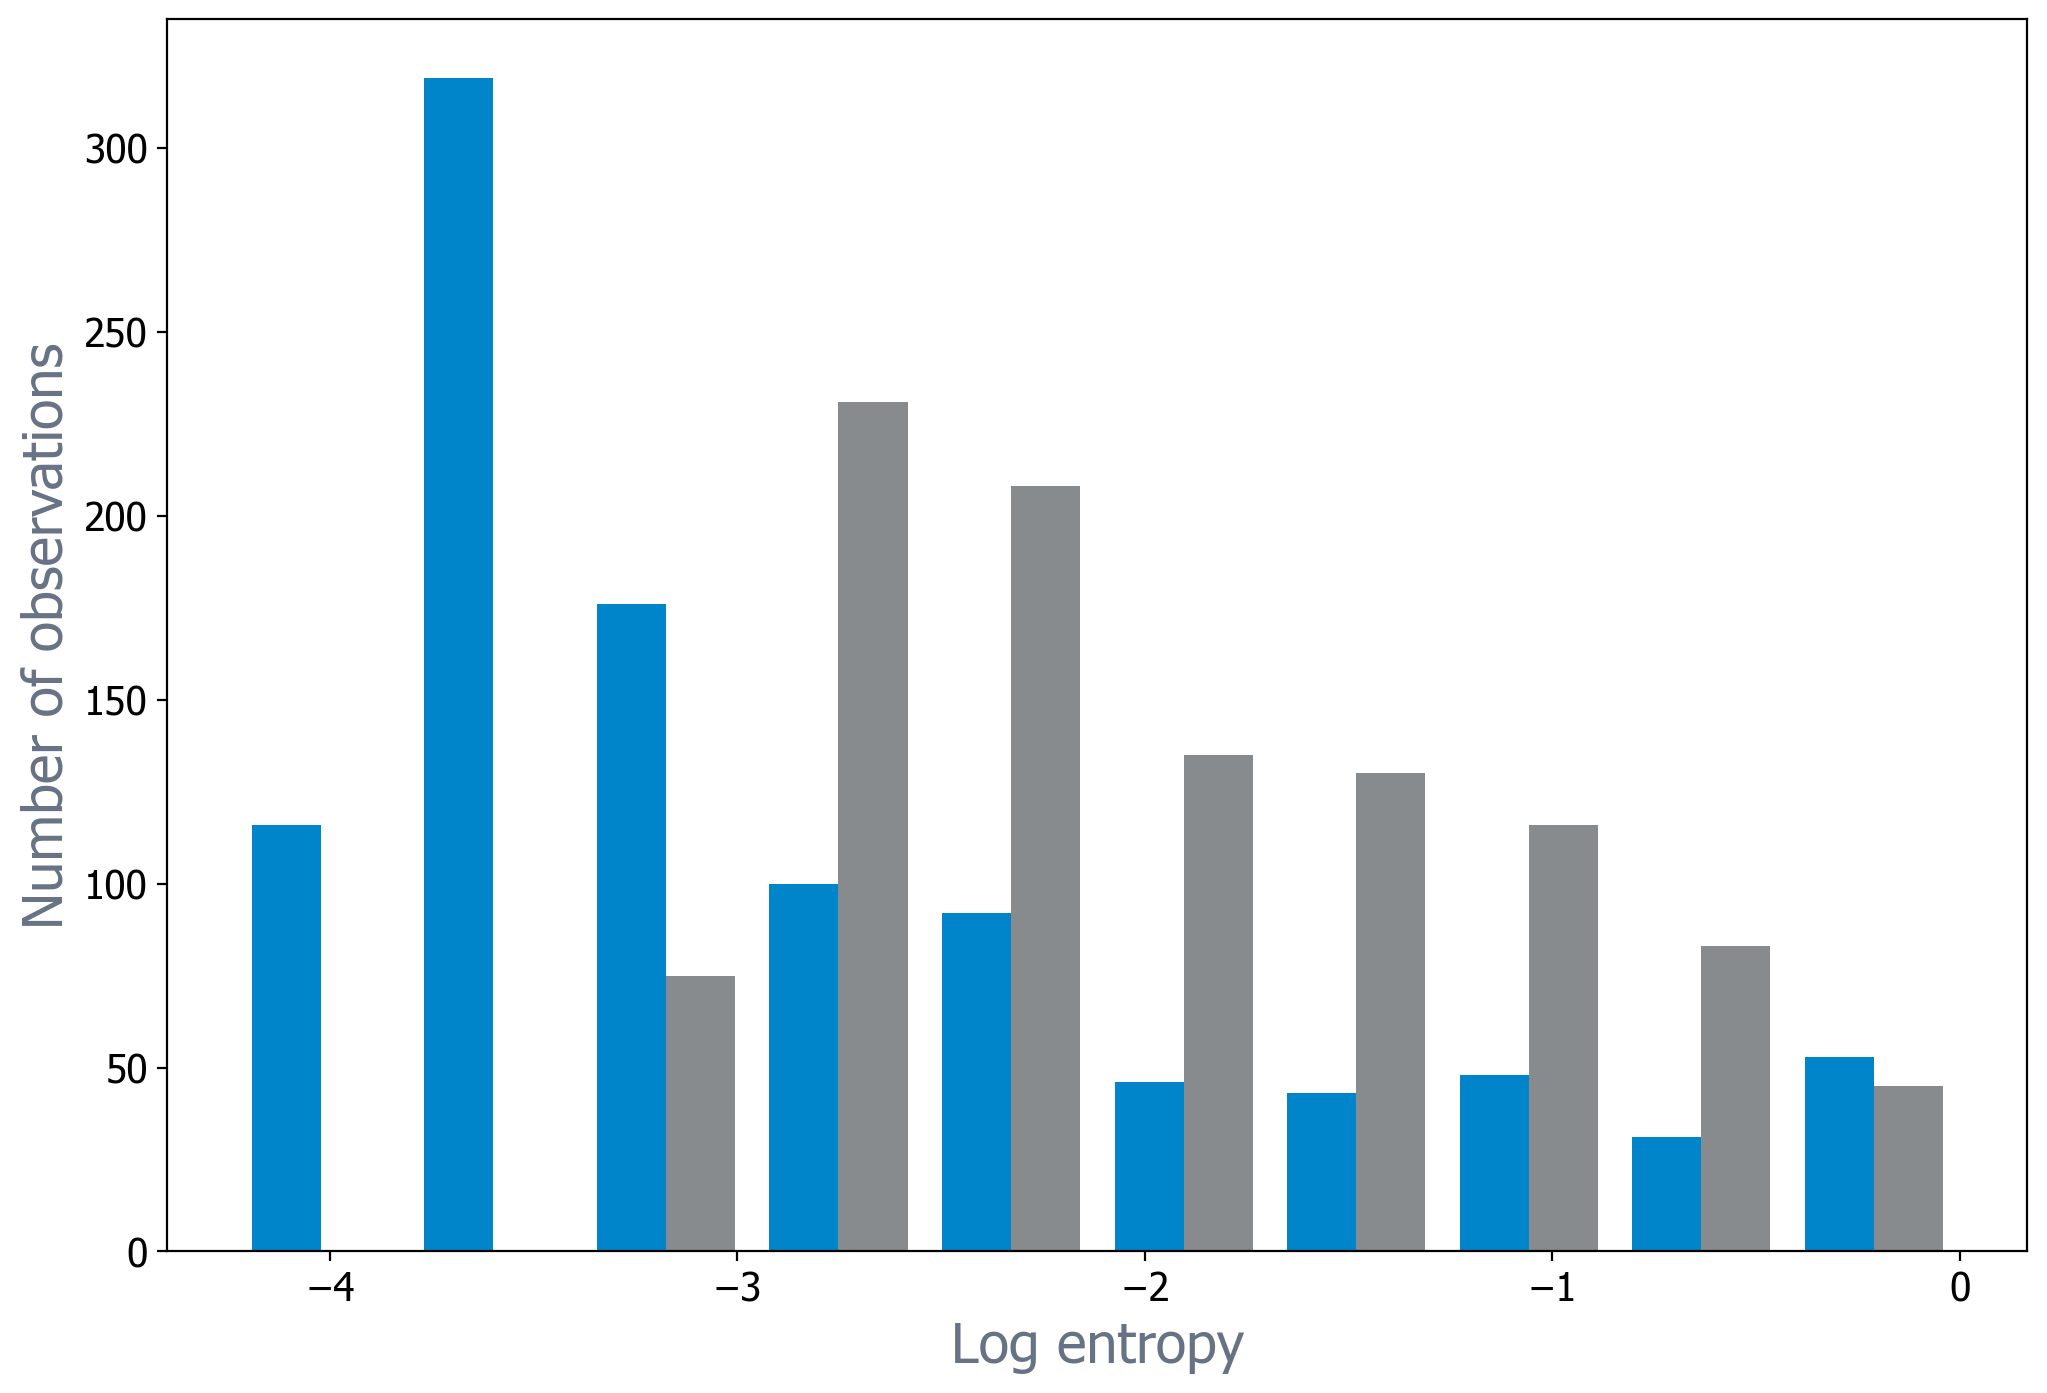

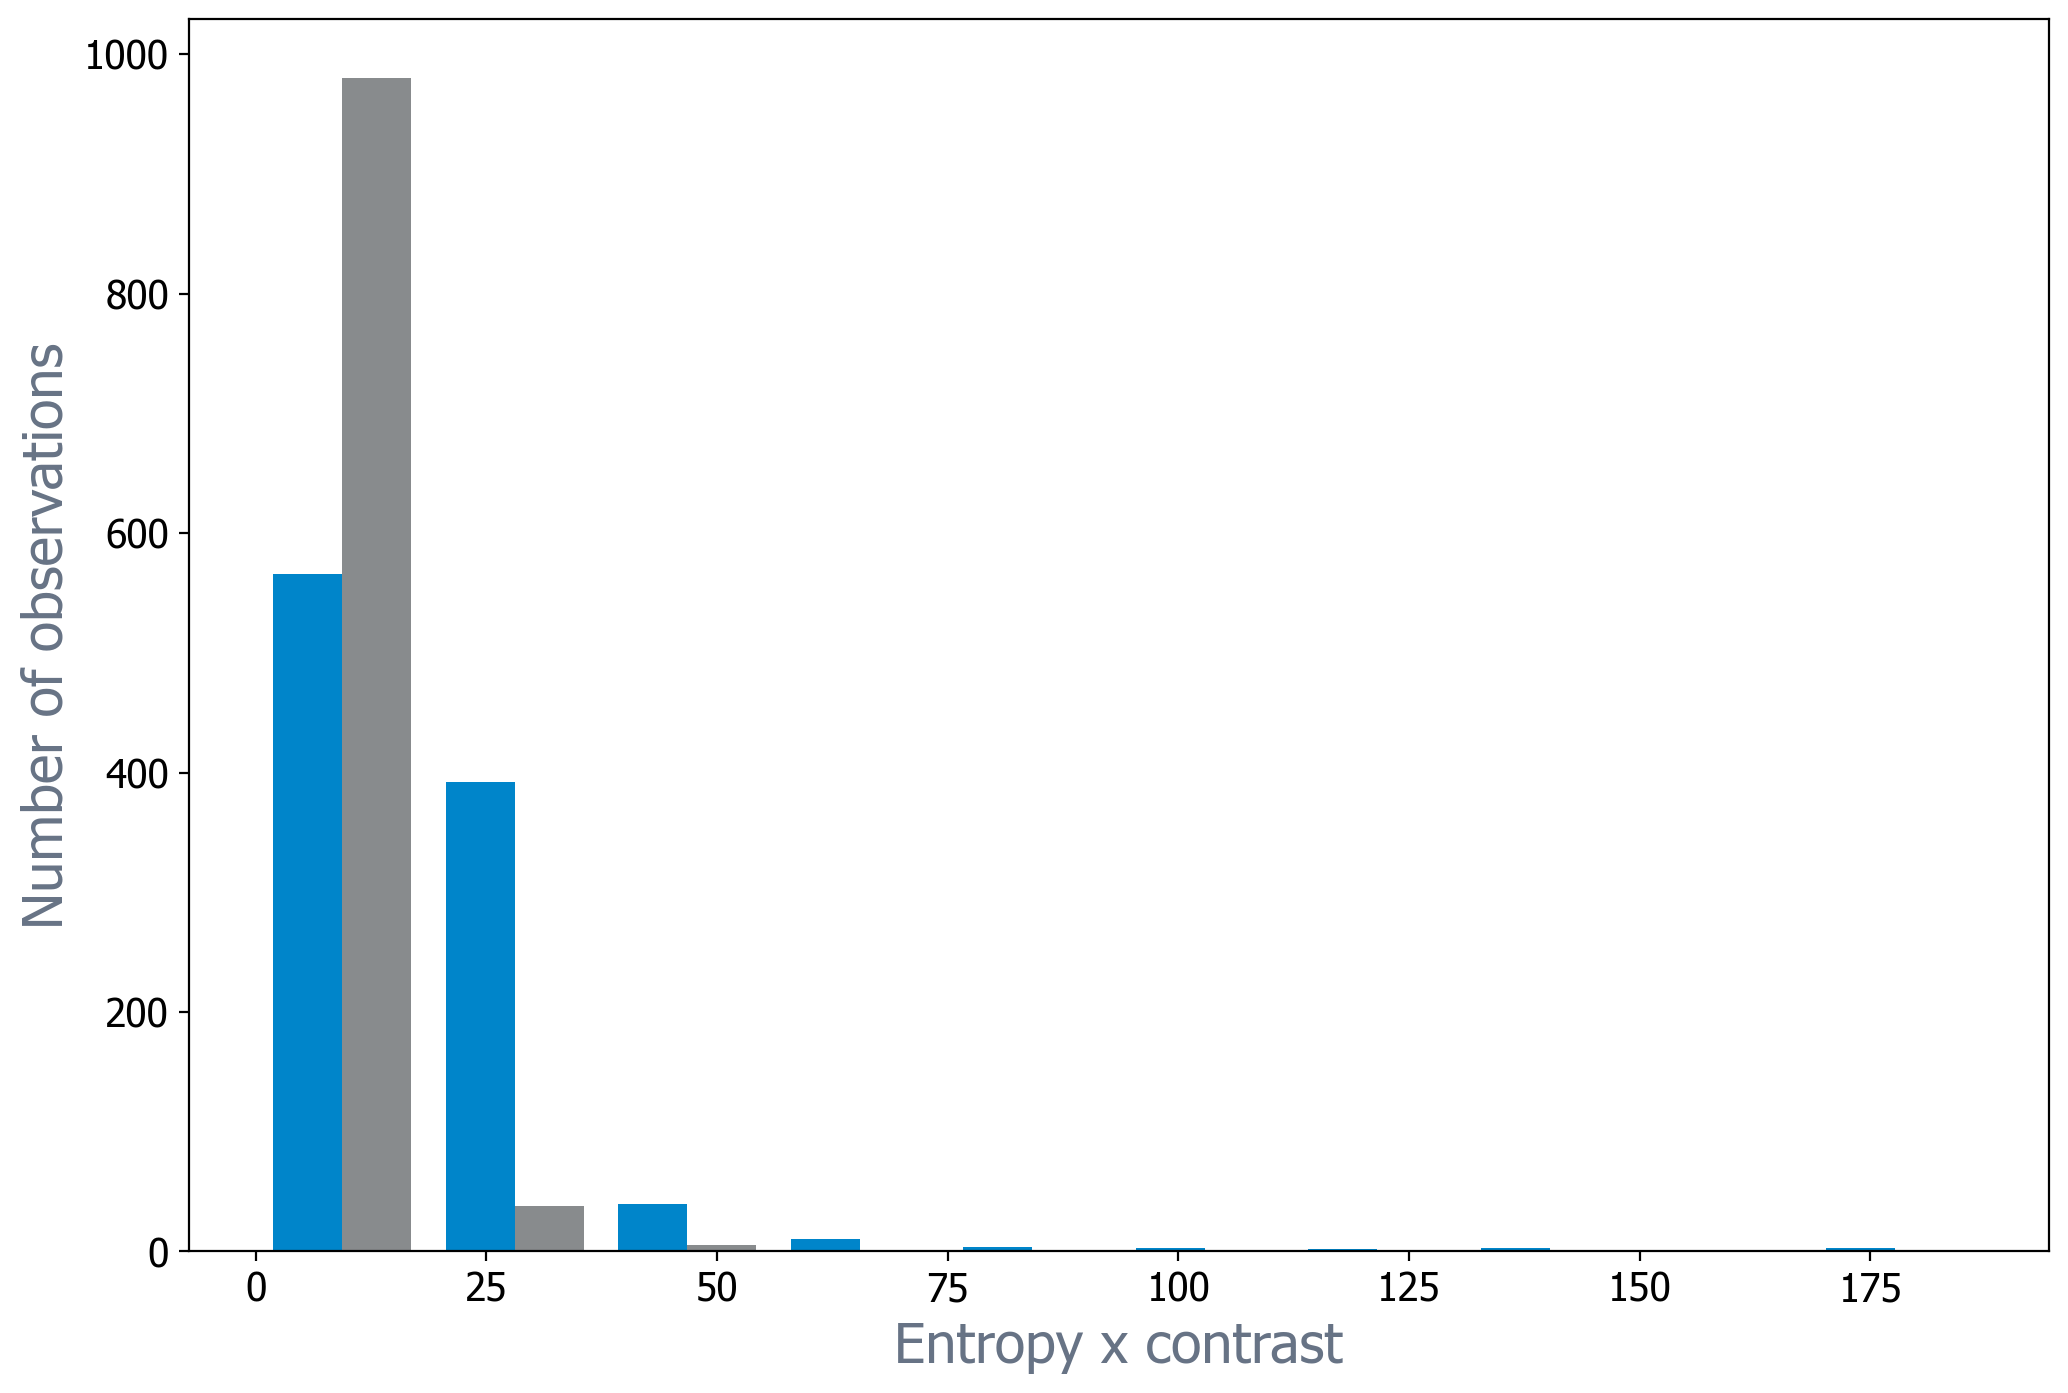

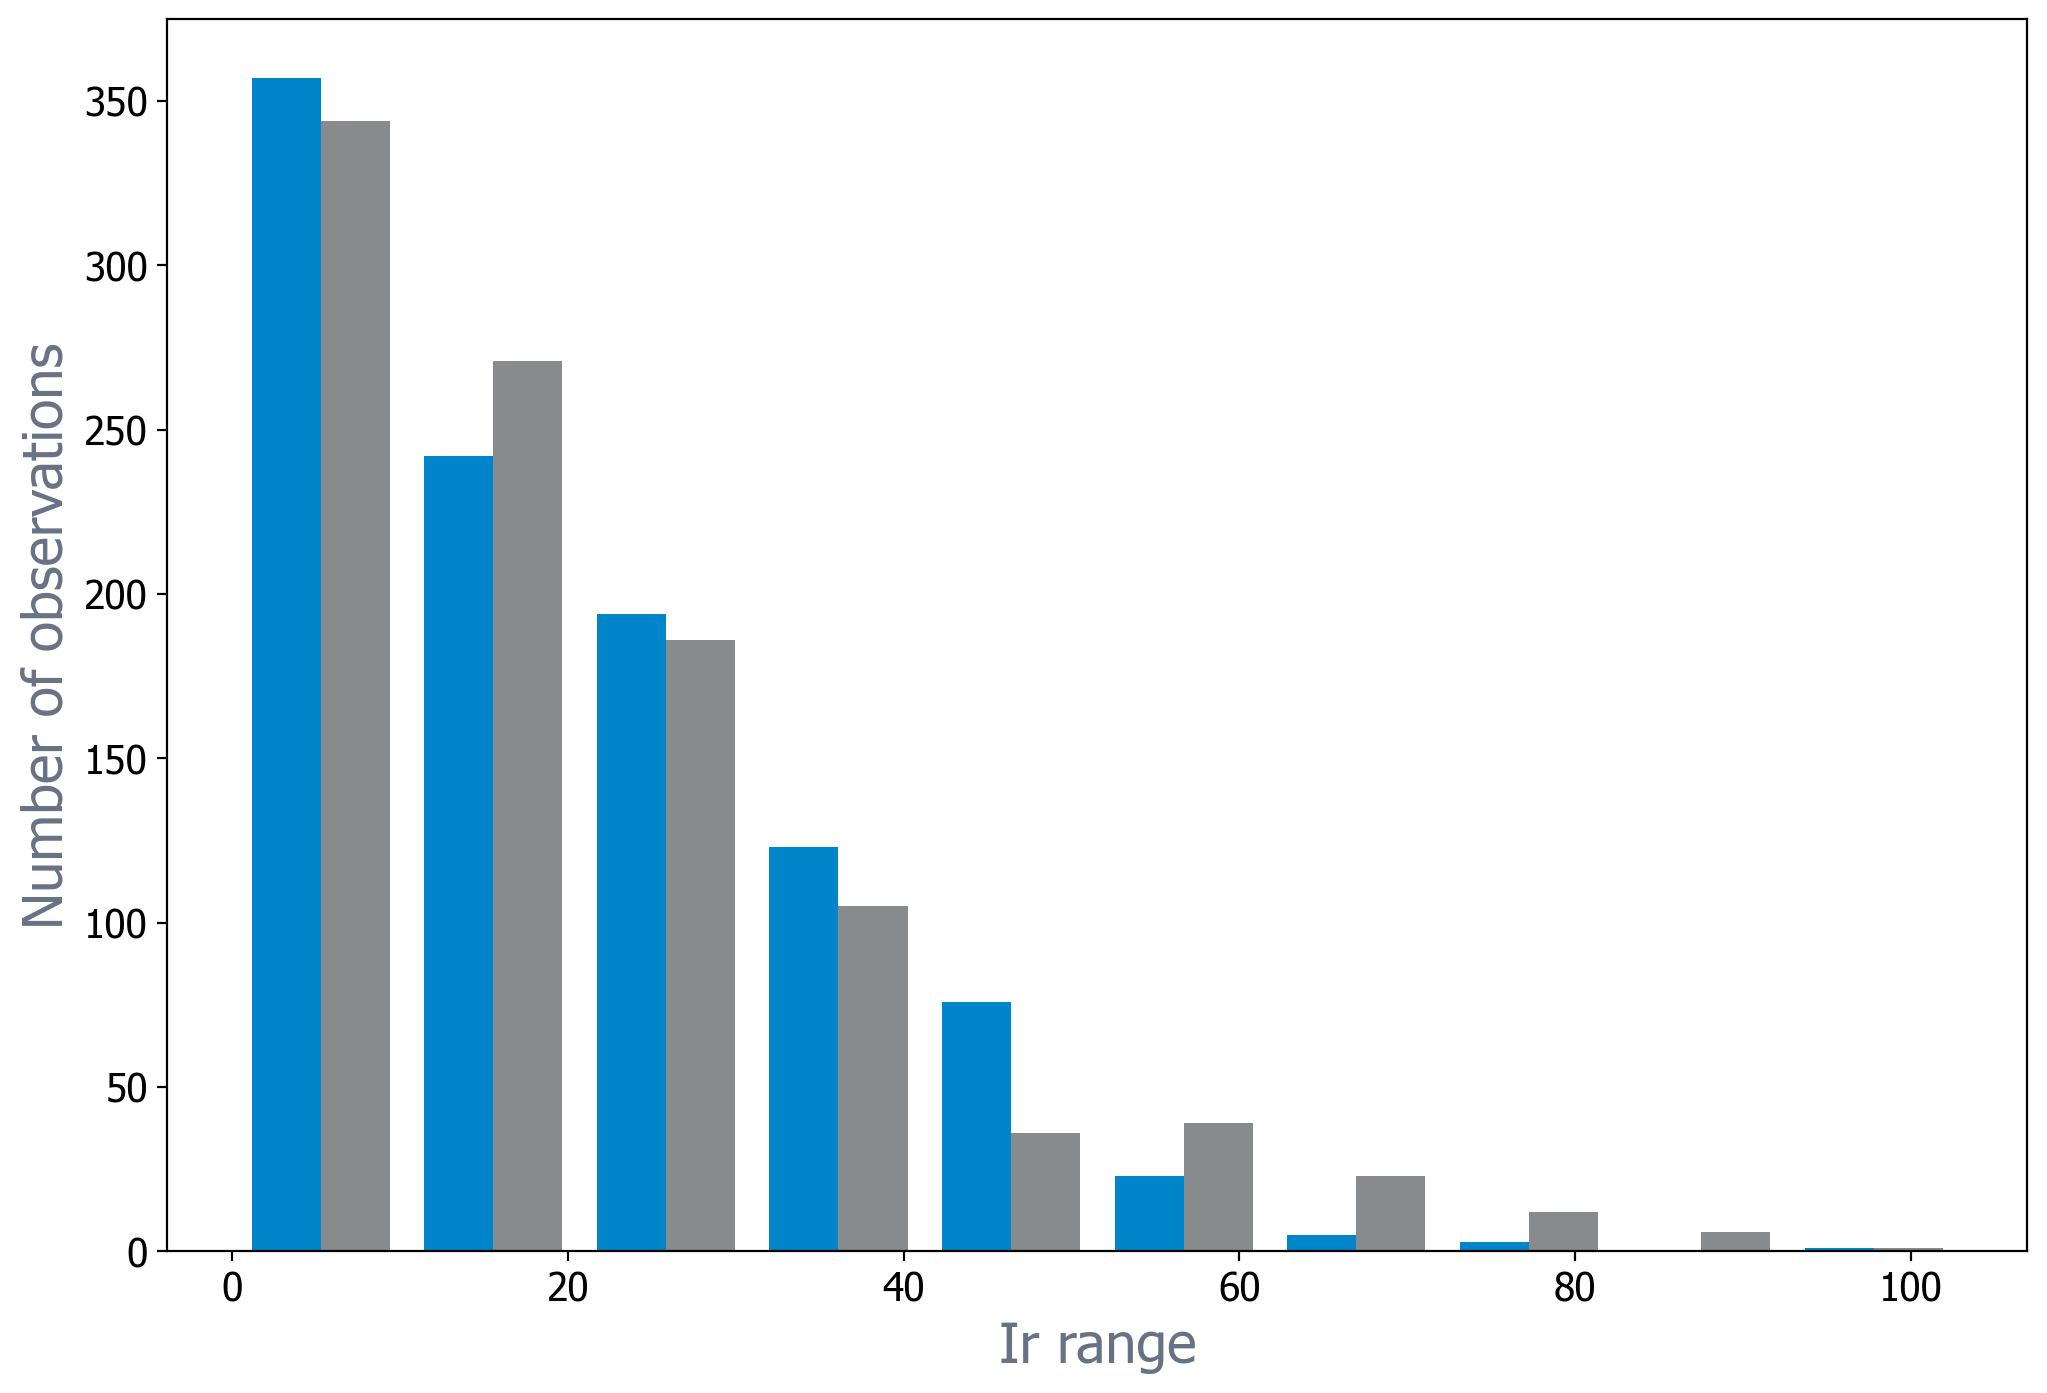

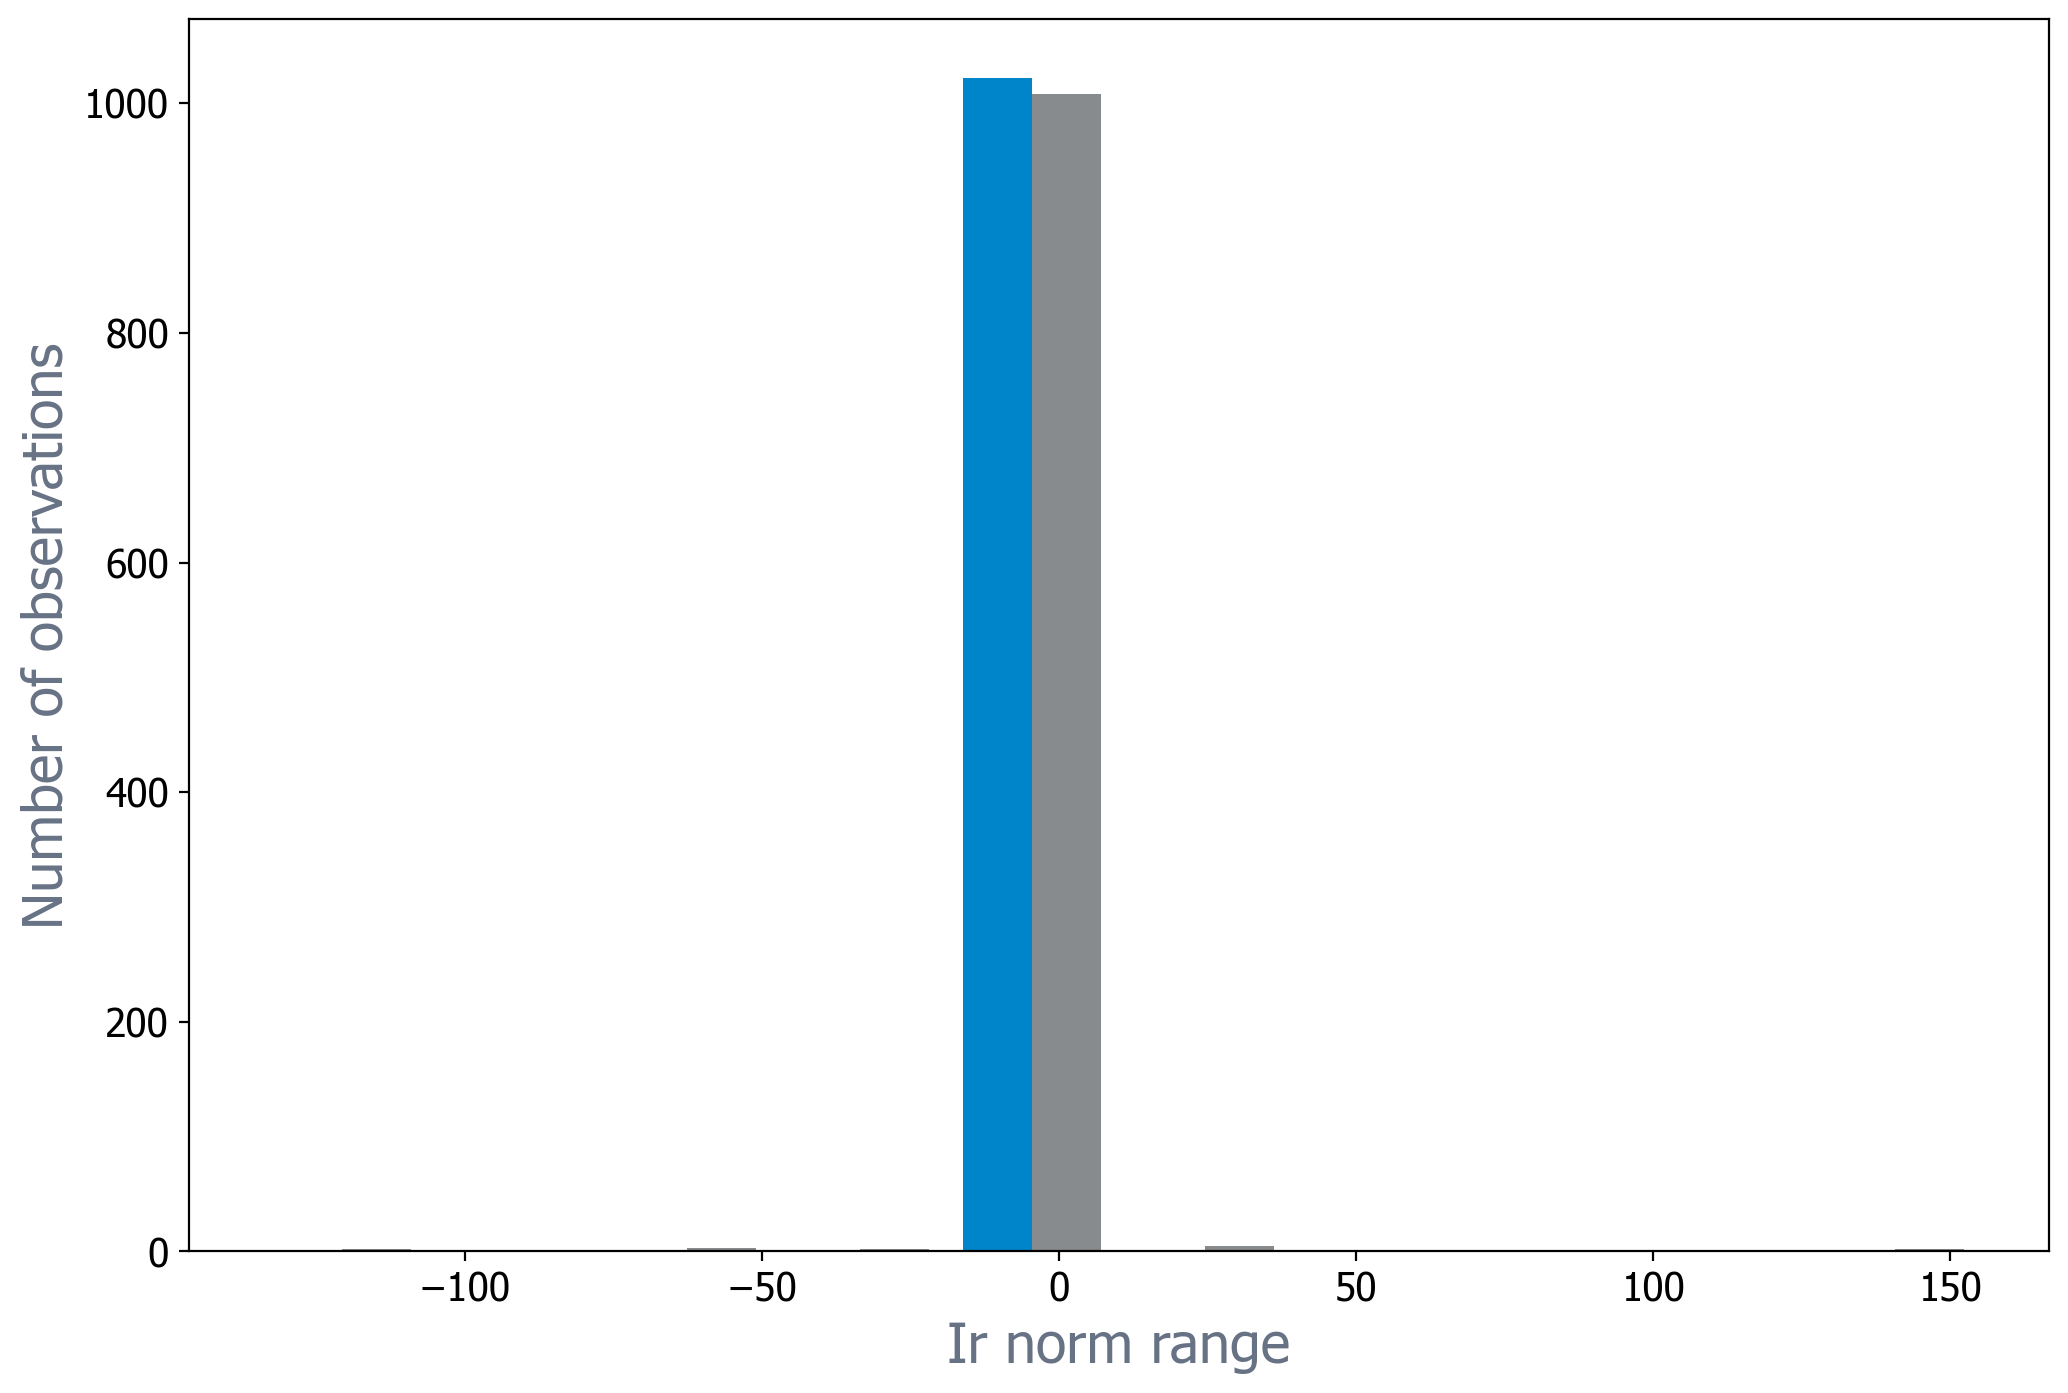

In [25]:
figs = []
for feat in features.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist([
        features[target == 0][feat].values, features[target == 1][feat].values
    ])
    ax.set_xlabel(' '.join(feat.split('_')).capitalize())
    ax.set_ylabel('Number of observations')
    figs.append(fig)

## Split data into test and train

In [26]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    features, target, test_size=0.4)

# Train model

In [27]:
initial_features = ['log_entropy', 'IR_norm_range', 'entropy_x_contrast']

In [28]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=10, max_depth=10)

In [29]:
rf.fit(X_train[initial_features], y_train)

RandomForestClassifier(max_depth=10, n_estimators=10)

In [30]:
dir(rf)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_compute_oob_predictions',
 '_estimator_type',
 '_get_oob_predictions',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_oob_score_and_attributes',
 '_validate_X_predict',
 '_validate_data',
 '_validate_estimator',
 '_validate_y_class_weight',
 'apply',
 'base_estimator',
 'base_estimator_',
 'bootstrap',
 'ccp_alpha',
 'class_weight'

In [31]:
type(rf)

sklearn.ensemble._forest.RandomForestClassifier

In [32]:
isinstance(rf, sklearn.ensemble._forest.RandomForestClassifier)

True

In [33]:
attributes = dict()
for modelatt in dir(rf):
    try:
        att_val = getattr(rf, modelatt)
        print(modelatt, ': ', type(att_val), )
        attributes[modelatt] = att_val
    except:
        print('error', modelatt)

__abstractmethods__ :  <class 'frozenset'>
__annotations__ :  <class 'dict'>
__class__ :  <class 'abc.ABCMeta'>
__delattr__ :  <class 'method-wrapper'>
__dict__ :  <class 'dict'>
__dir__ :  <class 'builtin_function_or_method'>
__doc__ :  <class 'str'>
__eq__ :  <class 'method-wrapper'>
__format__ :  <class 'builtin_function_or_method'>
__ge__ :  <class 'method-wrapper'>
__getattribute__ :  <class 'method-wrapper'>
__getitem__ :  <class 'method'>
__getstate__ :  <class 'method'>
__gt__ :  <class 'method-wrapper'>
__hash__ :  <class 'method-wrapper'>
__init__ :  <class 'method'>
__init_subclass__ :  <class 'builtin_function_or_method'>
__iter__ :  <class 'method'>
__le__ :  <class 'method-wrapper'>
__len__ :  <class 'method'>
__lt__ :  <class 'method-wrapper'>
__module__ :  <class 'str'>
__ne__ :  <class 'method-wrapper'>
__new__ :  <class 'builtin_function_or_method'>
__reduce__ :  <class 'builtin_function_or_method'>
__reduce_ex__ :  <class 'builtin_function_or_method'>
__repr__ :  <cl

# Score model

In [34]:
ypred_proba_test = rf.predict_proba(X_test[initial_features])[:,1]
ypred_bin_test = rf.predict(X_test[initial_features])

# Evaluate performance

In [35]:
auc = sklearn.metrics.roc_auc_score(y_test, ypred_proba_test)
confusion = sklearn.metrics.confusion_matrix(y_test, ypred_bin_test)
accuracy = sklearn.metrics.accuracy_score(y_test, ypred_bin_test)
classification_report = sklearn.metrics.classification_report(y_test, ypred_bin_test)

In [36]:
print('AUC on test: %0.3f' % auc)
print('Accuracy on test: %0.3f' % accuracy)
print()
print(pd.DataFrame(confusion,
                  index=['Actual negative','Actual positive'],
                  columns=['Predicted negative', 'Predicted positive']))

AUC on test: 1.000
Accuracy on test: 0.990

                 Predicted negative  Predicted positive
Actual negative                 414                   2
Actual positive                   6                 397


# Key findings
A classifier with very high accuracy has been developed that is ready for production. 


# Next steps
Move model over to scripts for productionalization

# Appendix

## Watermark 
For full reproducibility of results, use exact data extraction as defined at top of notebook and ensure that the environment is exactly as follows: 

In [39]:
# ! pip install watermark
%load_ext watermark
%watermark -v -m --iversions -g

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.6.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 5, GenuineIntel
CPU cores   : 20
Architecture: 64bit

Git hash: 995792a6c3c5e7fd18938fe4827b5100f511b954

numpy     : 1.21.5
matplotlib: 3.5.2
sklearn   : 0.0
seaborn   : 0.11.2
sys       : 3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]
json      : 2.0.9
pandas    : 1.5.3

